#### IMPORTs & HELPER FUNCTIONs

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics, PLOT_KL_DIV, PLOT_MAGNETISATION, PLOT_MCMC_STATISTICS, ProcessMCMCData
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact


import pickle
import os 


### BAS dataset energy model
### class to generate BAS dataset of arbitrary gridsize.
from itertools import permutations, product
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()
# hebbing learning
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts
# def define_random_spin_ising_model(n_spins:int,seed_val:int):
#     # define the model # seed 4
#     np.random.seed(seed_val)#(610358)# should always be in the same cell!  ## best seed -> 610358

#     ## construct problem Hamiltonian ##
#     shape_of_J=(n_spins,n_spins)

#     ## defining J matrix (mutual 1-1 interaction)
#     J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
#     J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
#     J = 0.5 * (J + J.transpose() )
#     J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

#     # defining h
#     h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
#     # instantiate the model
#     model = IsingEnergyFunction(J, h, name= 'my_model')
#     return model

# # this function would be useful for plotting curves
# def plot_with_error_band(xval:list,y_list_of_list:list,label:str,
#                             std_dev_multiplicative_factor:int=0.5,
#                             alpha_for_plot:float=0.5):
# # for i, data in dict_mcmc_bas_gridsize_3.items():
# #     print(i)
# #     keys = list(data.keys())
# #     for type in keys:
# #         print(type)
# #         print(name_replacement[type])
# #         data[name_replacement[type]] = data.pop(type)
        
# # name_replacement = {'cl': 'cl-uniform', 'local': 'cl-local-wt1', 'Q-MCMC:pauli_wt_1': 'qu-wt1', 'Q-MCMC:pauli_wt_3': 'qu-wt3', 'local_wt_3': 'cl-local-wt3'}
#     curve_of_mean_value=np.mean(y_list_of_list,axis=0)
#     standard_dev_band=np.std(y_list_of_list,axis=0)
#     plt.plot(xval,curve_of_mean_value,"-",label=label)
#     plt.fill_between(xval,
#                         curve_of_mean_value-standard_dev_band* std_dev_multiplicative_factor,
#                         curve_of_mean_value+standard_dev_band* std_dev_multiplicative_factor,
#                         alpha=alpha_for_plot)
# class ProcessMCMCData():
    
#     import os
#     def __init__(self, data: dict, model: Exact_Sampling, savefile_path: str = None, name: str= 'SAMPLINGRESULT'):

#         self.data = data
#         self.model = model
#         self.processed_data = {}
#         self.savefile_path = savefile_path
#         self.name = name 
        
#         self.seeds = list(self.data.keys())
#         self.mcmc_types = list(self.data[1].keys())
        
#         # os.chdir(self.savefile_path)
#         print('OUTPUT DIRECTORY: ', os.path.join( os.getcwd(), self.savefile_path) )
    
#     def PROCESS_ALL(self,save_data= True):
        
#         self.CALCULATE_KL_DIV(save_data= save_data  )
#         self.CALCULATE_MAGNETISATION(save_data= save_data  )
#         self.CALCULATE_MCMC_STATISTICS(save_data= save_data  )
    
#     def UPDATE_DATA(self, new_data: dict, new_seeds, new_mcmc_types, save_data = True):

#         if self.processed_data == {} :
#             raise ValueError(' method ''UPDATE_DATA'' cannot be called on unprocessed data, call "PROCESS_ALL" intially ')

#         self.data = new_data
#         self.CALCULATE_KL_DIV(save_data= save_data, allow_reprocessing=True, seeds_new= new_seeds, mcmc_types_new= new_mcmc_types )
#         self.CALCULATE_MAGNETISATION(save_data= save_data, allow_reprocessing=True, seeds_new= new_seeds, mcmc_types_new= new_mcmc_types )
#         self.CALCULATE_MCMC_STATISTICS(save_data= save_data, allow_reprocessing=True, seeds_new= new_seeds, mcmc_types_new= new_mcmc_types )
        
#         self.seeds = list(self.data.keys())
#         self.mcmc_types = list(self.data[1].keys())
    
#     def PLOT_KL_DIV(self, save_plot = False, mcmc_types_to_plot = 'all'):
    
#         ## plotting
#         x=list(range(0,15000+1))
#         plt.figure(figsize=(12,8))
#         if mcmc_types_to_plot == 'all': 
#             mcmc_types_to_plot = self.processed_data['KL-DIV'].keys()
#         for mcmc_type in mcmc_types_to_plot:
#             plot_with_error_band(x, self.processed_data['KL-DIV'][mcmc_type] ,label= mcmc_type)
    
#         plt.xlabel("iterations ")
#         plt.ylabel("KL divergence")
#         plt.yscale('log')
#         plt.legend()

#         if save_plot:
#                 os.chdir(self.savefile_path)      
#                 figname = self.name + 'KL-DIV.pdf'
#                 plt.savefig(figname)
        
#                 os.chdir('../..')        
        
#         plt.show()

#     def CALCULATE_KL_DIV(self, save_data:bool= False, allow_reprocessing= False, seeds_new = None, mcmc_types_new= None  ):
        
#         ## data processing    
#         if 'KL-DIV' not in self.processed_data:
#             seeds = self.seeds
#             mcmc_types = self.mcmc_types
#             self.processed_data['KL-DIV'] = { mcmc_type: [] for mcmc_type in self.mcmc_types }

#         if allow_reprocessing:
#             if seeds_new == None: seeds = self.seeds
#             else: seeds = seeds_new
            
#             if mcmc_types_new == None: mcmc_types = self.mcmc_types 
#             else: 
#                 mcmc_types = mcmc_types_new
#                 for mcmc_type in mcmc_types:
#                     self.processed_data['KL-DIV'][mcmc_type] = []

#         if 'KL-DIV' not in self.processed_data or allow_reprocessing:
#             for seed in tqdm(seeds):
#                 for mcmc_type in mcmc_types:
          
#                     kldiv = calculate_running_kl_divergence(self.model.boltzmann_pd, self.data[seed][mcmc_type])
#                     self.processed_data['KL-DIV'][mcmc_type].append(kldiv)

#             if save_data :
#                 os.chdir(self.savefile_path)                
#                 with open(self.name + '.pkl','wb') as f:
#                         pickle.dump(self,f)
#                 os.chdir('../..')


#     def PLOT_MAGNETISATION(self, save_plot= False , mcmc_types_to_plot = 'all'):
    
#         ## plotting
#         fig, ax1 = plt.subplots(figsize=(12,8))
#         left, bottom, width, height = [0.55, 0.2, 0.25, 0.25]

#         x=list(range(0,15000))
#         # mcmc_types = self.data[1].keys()
#         if mcmc_types_to_plot == 'all': 
#             mcmc_types_to_plot = self.processed_data['MAGNETISATION'].keys()
        
#         for mcmc_type in mcmc_types_to_plot:
            
#             mean_mag_local=np.mean(self.processed_data['MAGNETISATION'][mcmc_type],axis=0)
#             std_local=np.std(self.processed_data['MAGNETISATION'][mcmc_type],axis=0)
#             ax1.plot(x,mean_mag_local,label= mcmc_type)
#             ax1.fill_between(x,mean_mag_local-std_local/2,mean_mag_local+std_local/2,alpha=0.45)


#         ax1.axhline(self.model.get_observable_expectation(magnetization_of_state), label= 'actual',linestyle='--')
#         ax1.legend()
#         ax1.set_xlabel("Iterations")
#         ax1.set_ylabel("Magnetisation")
        
#         if save_plot:       
#                 os.chdir(self.savefile_path)         
#                 figname = self.name + 'MAGNETISATION.pdf'
#                 plt.savefig(figname)
#                 os.chdir('../..')        
            
#         plt.show()

#     def CALCULATE_MAGNETISATION(self, save_data:bool = False , allow_reprocessing= False, seeds_new = None, mcmc_types_new= None  ):
        
#         ## data processing
#         if 'MAGNETISATION' not in self.processed_data:
#             seeds = self.seeds
#             mcmc_types = self.mcmc_types
#             self.processed_data['MAGNETISATION'] = { mcmc_type: [] for mcmc_type in mcmc_types }
#             magnetization_model = self.model.get_observable_expectation(magnetization_of_state)

#         if allow_reprocessing:
#             if seeds_new == None: seeds = self.seeds
#             else: seeds = seeds_new
            
#             if mcmc_types_new == None: mcmc_types = self.mcmc_types 
#             else: 
#                 mcmc_types = mcmc_types_new
#                 for mcmc_type in mcmc_types:
#                     self.processed_data['MAGNETISATION'][mcmc_type] = []


#         if 'MAGNETISATION' not in self.processed_data or allow_reprocessing:
        
#             for seed in tqdm(seeds):
#                 for mcmc_type in mcmc_types:
#                     mag = calculate_runnning_magnetisation(self.data[seed][mcmc_type], verbose= False)
#                     self.processed_data['MAGNETISATION'][mcmc_type].append(mag)


#             if save_data :
#                 os.chdir(self.savefile_path)
                
#                 with open(self.name + '.pkl','wb') as f:
#                         pickle.dump(self,f)
#                 os.chdir('../..') 

#     def PLOT_MCMC_STATISTICS(self,  save_plot= True, mcmc_types_to_plot = 'all' , statistic_to_plot:str= 'acceptance_prob'):
    
#         ## plotting
#         plt.figure(1,figsize=(20,15))
        
#         if mcmc_types_to_plot == 'all': 
#             mcmc_types_to_plot = self.processed_data['MAGNETISATION'].keys()

#         dim1 = int(len(self.data.keys()) / 2); dim2 = 2
#         for seed in tqdm(self.seeds):
#             for mcmc_type in mcmc_types_to_plot:
#                 stat_to_plot = self.processed_data['MCMC-STATISTICS'][seed][mcmc_type][statistic_to_plot] 
                
#                 plt.subplot(dim1,dim2,seed)

#                 if statistic_to_plot == 'acceptance_prob':
#                     plt.hist(np.log10(stat_to_plot),
#                         label= mcmc_type ,alpha= 0.5, 
#                         bins= 50,density=True)
                    
#                     if seed==9 or seed==10:
#                         plt.xlabel("log(Acceptance Rate)")
#                 else : 
#                     plt.hist(stat_to_plot,
#                         label= mcmc_type ,alpha= 0.1, 
#                         bins= 50,density=True)
                    
#                     if seed==9 or seed==10:
#                         plt.xlabel(statistic_to_plot)
        
#             plt.legend()
            
#         if save_plot:
#             os.chdir(self.savefile_path)
#             figname  = self.name + 'ACCEPTANCEPROB.pdf'
#             plt.savefig(figname)
#             os.chdir('../..')

#             plt.show()
        
#     def CALCULATE_MCMC_STATISTICS(self, save_data: bool = False, allow_reprocessing= False, seeds_new = None, mcmc_types_new= None ):

#         ## data processing ##        
#         if 'MCMC-STATISTICS' not in self.processed_data:
#             seeds = self.seeds
#             mcmc_types = self.mcmc_types
#             self.processed_data['MCMC-STATISTICS'] = { seed: {} for seed in seeds }
        
#         if allow_reprocessing :
#             if seeds_new == None: seeds = self.seeds
#             else: 
#                 seeds = seeds_new
#                 for seed in seeds:
#                     self.processed_data['MCMC-STATISTICS'][seed] = {}
            
#             if mcmc_types_new == None: mcmc_types = self.mcmc_types 
#             else: mcmc_types = mcmc_types_new
        
#         if 'MCMC-STATISTICS' not in self.processed_data or allow_reprocessing :
            
#             for seed in tqdm(seeds, desc= "Processing MCMC Statistics"):
#                 for mcmc_type in mcmc_types:
#                     self.processed_data['MCMC-STATISTICS'][seed][mcmc_type] = {}
#                     stat_data = get_trajectory_statistics(self.data[seed][mcmc_type], self.model)
#                     for stat in stat_data.keys():
#                         self.processed_data['MCMC-STATISTICS'][seed][mcmc_type][stat] = stat_data[stat]
            
#             if save_data:
#                 os.chdir(self.savefile_path)

#                 with open(self.name + '.pkl', 'wb') as f:
#                     pickle.dump(self, f)
                
#                 os.chdir('../..')



       
# def plot_mcmc_iterations(DATA) :
#     mcmc_types = list(DATA.keys())
#     iter_begin = 100; iter_end = -1
#     dim1 = int(len(mcmc_types)/2)+1; dim2 = 2

#     plt.figure(figsize=(40,25))
#     for j in range(1, len(mcmc_types)+1):
#         # print(j)
#         plt.subplot(dim1, dim2, j)
#         plt.plot(DATA[mcmc_types[j-1]].markov_chain[iter_begin: iter_end] )
#         plt.title(mcmc_types[j-1])

#         # plt.legend()
#     plt.show()


In [2]:
## HELPER FUNCTIONS ###
def PLOT_MCMC_STATISTICS(self,  save_plot= False, mcmc_types_to_plot = 'all' , statistic_to_plot:str= 'acceptance_prob', kwargs_hamming = {'type': ['total', 'accepted'], 'width': 0.13}, kwargs_acceptance_prob= {'histtype':'stepfilled', 'stacked': True, 'density': True}):
    
        ## plotting
        plt.figure(1,figsize=(20,15))
        
        if mcmc_types_to_plot == 'all': 
            mcmc_types_to_plot = list(self.processed_data['MAGNETISATION'].keys())

        dim1 = int(len(self.data.keys()) / 2); dim2 = 2
        
        
        if statistic_to_plot == 'acceptance_prob':
            mcmc_labels = [mcmc_type for mcmc_type in mcmc_types_to_plot]
            for seed in tqdm(self.seeds):    
                
                    # stat_to_plot = [ np.log10( self.processed_data['MCMC-STATISTICS'][seed][mcmc_type][statistic_to_plot] ) for mcmc_type in mcmc_types_to_plot]
                    
                    plt.subplot(dim1,dim2,seed)

                    # for mcmc_label in mcmc_labels:
                    #     stat_to_plot = np.log10( self.processed_data['MCMC-STATISTICS'][seed][mcmc_label][statistic_to_plot] )
                    #     x, bins, p = plt.hist(stat_to_plot,
                    #         label= mcmc_label ,alpha= 0.5, 
                    #         bins= np.linspace(-5,0,50), density= kwargs_acceptance_prob['density'],  histtype= kwargs_acceptance_prob['histtype'])
                    #     # print(sum(x))
                    #     # for item in p:
                    #             # item.set_height(item.get_height()/sum(x))
                    #     # print(p)
                    
                    max_ht = 0
                    for mcmc_label in mcmc_labels:
                        stat_to_plot = np.log10( self.processed_data['MCMC-STATISTICS'][seed][mcmc_label][statistic_to_plot] )
                        heights, bins = np.histogram(stat_to_plot, bins= np.linspace(-5,0,75) , density= True,)
                        heights = heights/sum(heights)
                        bin_centers = 0.5*(bins[1:] + bins[:-1])
                        bin_widths = np.diff(bins)
                        
                        plt.bar(bin_centers, heights, width=bin_widths, alpha=0.5, label = mcmc_label)    

                        if max(heights) > max_ht :
                             max_ht = max(heights)

                    if seed==9 or seed==10:
                        plt.xlabel("log(Acceptance Rate)")
                    
                    lgnd = plt.legend(loc='upper left', ncols= 4)
            
                    plt.ylim((0, max_ht + 0.05 ))        
            plt.show()        
                
        elif statistic_to_plot == 'hamming':
            mcmc_labels = [mcmc_type for mcmc_type in mcmc_types_to_plot]
            for seed in tqdm(self.seeds):
                
                ticks = list(self.processed_data['MCMC-STATISTICS'][seed][mcmc_types_to_plot[0]][statistic_to_plot].keys())
                
            
                plt.subplot(dim1,dim2,seed)

                width = kwargs_hamming['width']  
                x = np.arange(len(ticks))

                if 'total' in kwargs_hamming['type']:        
                    multiplier = 0            
                    for mcmc_type in mcmc_labels :
                        offset = width * multiplier
                        values_1 = [self.processed_data['MCMC-STATISTICS'][seed][mcmc_type][statistic_to_plot][key]['total'] for key in ticks ]
                        rects = plt.bar(x + offset, values_1, width, label= mcmc_type, alpha = 0.5, edgecolor = 'k')
                        # plt.bar_label(rects, padding=3)
                        multiplier += 1
                
                if 'accepted' in kwargs_hamming['type']:
                    multiplier = 0            
                    for mcmc_type in mcmc_labels :
                        offset = width * multiplier
                        values_2 = [self.processed_data['MCMC-STATISTICS'][seed][mcmc_type][statistic_to_plot][key]['accepted'] for key in ticks ]
                        if 'total' in kwargs_hamming['type']: rects = plt.bar(x + offset, values_2, width, alpha = 1.0, fill= False, edgecolor = 'k', hatch= '///')
                        else : rects = plt.bar(x + offset, values_2, width, alpha = 0.5, edgecolor = 'k', label= mcmc_type)
                        # plt.bar_label(rects, padding=3)
                        multiplier += 1
        
         
                plt.xticks(x + width, ticks)    
                if seed==9 or seed==10:
                    plt.xlabel(statistic_to_plot)
                
                lgnd = plt.legend(loc='upper left', ncols= len(mcmc_labels))
            plt.show()
                # print(lgnd.get_han())
        else :
            for seed in tqdm(self.seeds):        
                    plt.subplot(dim1,dim2,seed)

                    plt.hist(stat_to_plot,
                        label= mcmc_type ,alpha= 0.1, 
                        bins= 50,density=True)
                    
                    if seed==9 or seed==10:
                        plt.xlabel(statistic_to_plot)
            
            plt.legend(loc='upper left', ncols=3)
            
        
            
        if save_plot:
            os.chdir(self.savefile_path)
            figname  = self.name + '_' + statistic_to_plot
            plt.savefig(figname)
            os.chdir('../..')

        
            
def PLOT_MAGNETISATION(self, save_plot= False , mcmc_types_to_plot = 'all'):
    
        ## plotting
        fig, ax1 = plt.subplots(figsize=(26,16))
        left, bottom, width, height = [0.55, 0.2, 0.25, 0.25]

        x=list(range(0,15000))
        # mcmc_types = self.data[1].keys()
        if mcmc_types_to_plot == 'all': 
            mcmc_types_to_plot = self.processed_data['MAGNETISATION'].keys()
        
        for mcmc_type in mcmc_types_to_plot:
            
            mean_mag_local=np.mean(self.processed_data['MAGNETISATION'][mcmc_type],axis=0)
            std_local=np.std(self.processed_data['MAGNETISATION'][mcmc_type],axis=0)
            ax1.plot(x,mean_mag_local,label= mcmc_type)
            ax1.fill_between(x,mean_mag_local-std_local/2,mean_mag_local+std_local/2,alpha=0.45)


        ax1.axhline(self.model.get_observable_expectation(magnetization_of_state), label= 'actual',linestyle='--')
        ax1.legend()
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Magnetisation")
        
        if save_plot:       
                os.chdir(self.savefile_path)         
                figname = self.name + 'MAGNETISATION.pdf'
                plt.savefig(figname)
                os.chdir('../..')        
            
        plt.show()

def PLOT_KL_DIV(self, save_plot = False, mcmc_types_to_plot = 'all'):
    
        ## plotting
        x=list(range(0,15000+1))
        plt.figure(figsize=(12,8))
        if mcmc_types_to_plot == 'all': 
            mcmc_types_to_plot = self.processed_data['KL-DIV'].keys()
        for mcmc_type in mcmc_types_to_plot:
            plot_with_error_band(x, self.processed_data['KL-DIV'][mcmc_type] ,label= mcmc_type)
    
        plt.xlabel("iterations ")
        plt.ylabel("KL divergence")
        plt.yscale('log')
        plt.legend()

        if save_plot:
                os.chdir(self.savefile_path)      
                figname = self.name + 'KL-DIV.pdf'
                plt.savefig(figname)
        
                os.chdir('../..')        
        
        plt.show()

### EXPERIMENTs

##### Generate Instance

In [3]:
# 
gridsize=3
bas=bas_dataset(grid_size=gridsize)
bas.dataset.sort()
# considering only stripes dataset
wt=hebbing_learning(bas.bas_dict['bars'])

# creating ising model for the bas stripes only dataset
n_spins=gridsize*gridsize
shape_of_J=(n_spins,n_spins)
J=-1*wt
h=np.zeros(n_spins)
model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars only')
#model.model_summary()

            MODEL : ising model BAS 9X9 bars only
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 0 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  2.6666666666666665
Average Bias Strength <|h|>:  0.0
alpha :  0.14433756729740643
---------------------------------------------


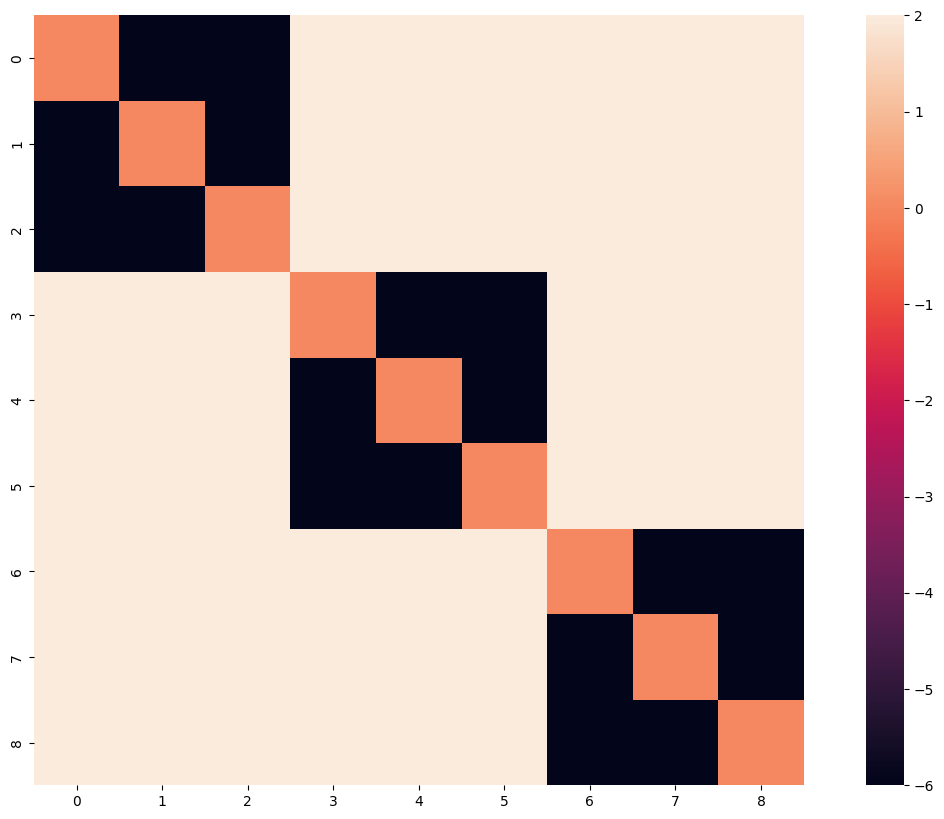

In [4]:
model.model_summary()

     MODEL : ising model BAS 9X9 bars only |  beta : 1.5
Num Most Probable States : 6
Entropy : 2.5849625007211547
---------------------------------------------


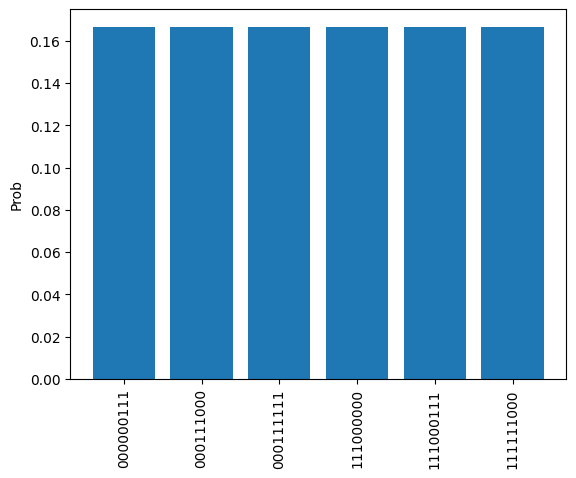

In [5]:
beta=1.5
## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get distribution from the model
bpd=exact_sampled_model.boltzmann_pd
exact_sampled_model.sampling_summary()

#### Run Experiments

In [6]:
num_different_chains=10

In [24]:
MCMC_SETTINGS = {
                'qu-wt1': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 1]] , [] ] },
                'qu-wt2':{'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 2]] , [] ] },
                'qu-wt3':{'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3]] , [] ] },
                'qu-alt-wt1-wt3' : {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3], ['random', 1]] , [0.5, 0.5] ] },
                'qu-stabilizers-wt3': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['custom', [[0,1,2], [3,4,5], [6,7,8]] ]], []] },
                'cl-uniform': {'mcmc_type': 'classical' , 'mixer' : [  [['uniform']], [] ] }, 
                'cl-local-wt1': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 1]], [] ] },
                'cl-local-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3]], [] ] },
                'cl-alt-wt1-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3], ['local', 1]], [0.5, 0.5] ] } 
                }


##### New Runs

In [22]:
# ## classical-uniform
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps=15000
#     #list_labels.append('classical uniform strategy')
#     cl_chain =classical_mcmc(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         proposition_method= MCMC_SETTINGS['cl-uniform']['mixer']       
#     )
    
#     SAMPLINGDATA_BAS3[seed_val]['cl-uniform'] = cl_chain

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


In [36]:
# ## classical-wt1
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps=15000
#     #list_labels.append('classical uniform strategy')
#     cl_chain =classical_mcmc(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         proposition_method= MCMC_SETTINGS['cl-local-wt1']['mixer']       
#     )
    
#     SAMPLINGDATA_BAS3[seed_val]['cl-local-wt1'] = cl_chain

100%|██████████| 10/10 [00:00<00:00, 30.55it/s]


In [ ]:
# ## classical-wt3
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps=15000
#     #list_labels.append('classical uniform strategy')
#     cl_chain =classical_mcmc(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         proposition_method= MCMC_SETTINGS['cl-local-wt3']['mixer']       
#     )
    
#     SAMPLINGDATA_BAS3[seed_val]['cl-local-wt3'] = cl_chain

In [9]:
# ## quantum-stabilizer-based-mixer
# for seed_val in tqdm(range(1,num_different_chains+1)):
# # quantum 2: 
#     steps = 15000
#     #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
#     qamcmc_chain_2 =quantum_enhanced_mcmc_2(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         verbose=False,
#         name='qu-stabilizer-wt3',
#         gamma_range=(0.1,0.4),
#         initial_state= np.random.choice(bas.bas_dict['bars']) , ## intialize from an element of dataset
#         mixer= [ [['custom', [[0,1,2], [3,4,5], [6,7,8]] ]], []]
#     )
#     SAMPLINGDATA_BAS3[seed_val]['qu-stabilizers-wt3']= qamcmc_chain_2

In [10]:
# ## quantum-wt3
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps = 15000
#     #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
#     qamcmc_chain_2 =quantum_enhanced_mcmc_2(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         verbose=False,
#         name='qu-wt3',
#         gamma_range=(0.1,0.4),
#         initial_state= np.random.choice(bas.bas_dict['bars']) , ## intialize from an element of dataset
#         mixer= [[['random', 3]  ], []  ],
#     )
#     SAMPLINGDATA_BAS3[seed_val]['qu-wt3']=qamcmc_chain_2
    

In [11]:
# ## quantum-wt2
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps = 15000
#     #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
#     qamcmc_chain_2 =quantum_enhanced_mcmc_2(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         verbose=False,
#         name='qu-wt2',
#         gamma_range=(0.1,0.4),
#         initial_state= np.random.choice(bas.bas_dict['bars']) , ## intialize from an element of dataset
#         mixer= [[['random', 2]  ], []  ],
#     )
#     SAMPLINGDATA_BAS3[seed_val]['qu-wt2']=qamcmc_chain_2
    

In [12]:
# ## quantum-wt1
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps = 15000
#     #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
#     qamcmc_chain_2 =quantum_enhanced_mcmc_2(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         verbose=False,
#         name='qu-wt1',
#         gamma_range=(0.1,0.4),
#         initial_state= np.random.choice(bas.bas_dict['bars']) , ## intialize from an element of dataset
#         mixer= [[['random', 1]  ], []  ],
#     )
#     SAMPLINGDATA_BAS3[seed_val]['qu-wt1']=qamcmc_chain_2
    

In [13]:
# ## quantum-alternating-wt 
# for seed_val in tqdm(range(1,num_different_chains+1)):

#     steps = 15000
#     #list_labels.append('QMCMC; pauli_wt-2; gamma range=(0.2,0.6)')
#     qamcmc_chain_2 =quantum_enhanced_mcmc_2(
#         n_hops=steps,
#         model=model,
#         temperature=1/beta,
#         verbose=False,
#         name='qu-alt-wt1-wt3',
#         gamma_range=(0.1,0.4),
#         initial_state= np.random.choice(bas.bas_dict['bars']) , ## intialize from an element of dataset
#         mixer= [[['random', 1], ['random', 3]  ], [0.5, 0.5]  ],
#     )
#     SAMPLINGDATA_BAS3[seed_val]['qu-alt-wt1-wt3']=qamcmc_chain_2
    

### RESULTS

In [14]:
# os.chdir('../..')

In [15]:
os.getcwd()

'/home/pafloxy/Documents/QBMS/quMCMC'

In [28]:
# ## dump data ##
# name=f'''SamplingData/BAS3/SAMPLINGDATA_BAS3.pkl'''
# with open(name,'wb') as f:
#         pickle.dump(SAMPLINGDATA_BAS3, f)

# # dump results ##
# name=f'''SamplingData/BAS3/SAMPLINGRESULT_BAS3.pkl'''
# with open(name,'wb') as f:
#         pickle.dump(SAMPLINGRESULT_BAS3, f)

#### Data-load

In [42]:
## load data ##
name=f'''SamplingData/BAS3/SAMPLINGDATA_BAS3.pkl'''
with open(name,'rb') as f:
        SAMPLINGDATA_BAS3 = pickle.load(f)

SAMPLINGDATA_BAS3;

name = 'SamplingData/BAS3/SAMPLINGRESULT_BAS3.pkl'
with open(name, 'rb') as r:
    SAMPLINGRESULT_BAS3 =  pickle.load(r)         

In [43]:
# SAMPLINGDATA_BAS3[1]['cl-uniform'], 
# SAMPLINGDATA_BAS3[1]['qu-stabilizers-wt3']
SAMPLINGRESULT_BAS3.processed_data['KL-DIV'].keys()

dict_keys(['cl-uniform', 'cl-local-wt1', 'qu-wt1', 'qu-wt3', 'cl-local-wt3', 'qu-alt-wt1-wt3', 'qu-wt2', 'qu-stabilizers-wt3', 'classical-uniform'])

In [44]:
# SAMPLINGRESULT_BAS3.UPDATE_DATA(SAMPLINGDATA_BAS3, None, ['qu-wt1', 'qu-wt3', 'qu-alt-wt1-wt3', 'qu-wt2','qu-stabilizers-wt3'], save_data= True )
# SAMPLINGRESULT_BAS3.UPDATE_DATA(SAMPLINGDATA_BAS3, None, ['cl-uniform'], save_data= True )

Processing MCMC Statistics: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


In [45]:
# SAMPLINGRESULT_BAS3 = ProcessMCMCData(SAMPLINGDATA_BAS3, exact_sampled_model, savefile_path= 'SamplingData/BAS3', name= 'SAMPLINGRESULT_BAS3')
# name = 'SamplingData/BAS3/SAMPLINGRESULT_BAS3.pkl'
# with open(name, 'wb') as w:
#     pickle.dump(SAMPLINGRESULT_BAS3, w)

# SAMPLINGRESULT_BAS3_ = ProcessMCMCData(SAMPLINGRESULT_BAS3.data, SAMPLINGRESULT_BAS3.model, SAMPLINGRESULT_BAS3.savefile_path, SAMPLINGRESULT_BAS3.name)
# SAMPLINGRESULT_BAS3_.processed_data = SAMPLINGRESULT_BAS3.processed_data 
# SAMPLINGRESULT_BAS3 = SAMPLINGRESULT_BAS3_

# SAMPLINGRESULT_BAS3.UPDATE_DATA(SAMPLINGDATA_BAS3, None, ['qu-wt2'],save_data=False)

#### Plots

##### Others

In [46]:
# SAMPLINGRESULT_BAS3.processed_data.keys(),SAMPLINGRESULT_BAS3.seeds, SAMPLINGRESULT_BAS3.mcmc_types

<Figure size 2500x1600 with 0 Axes>

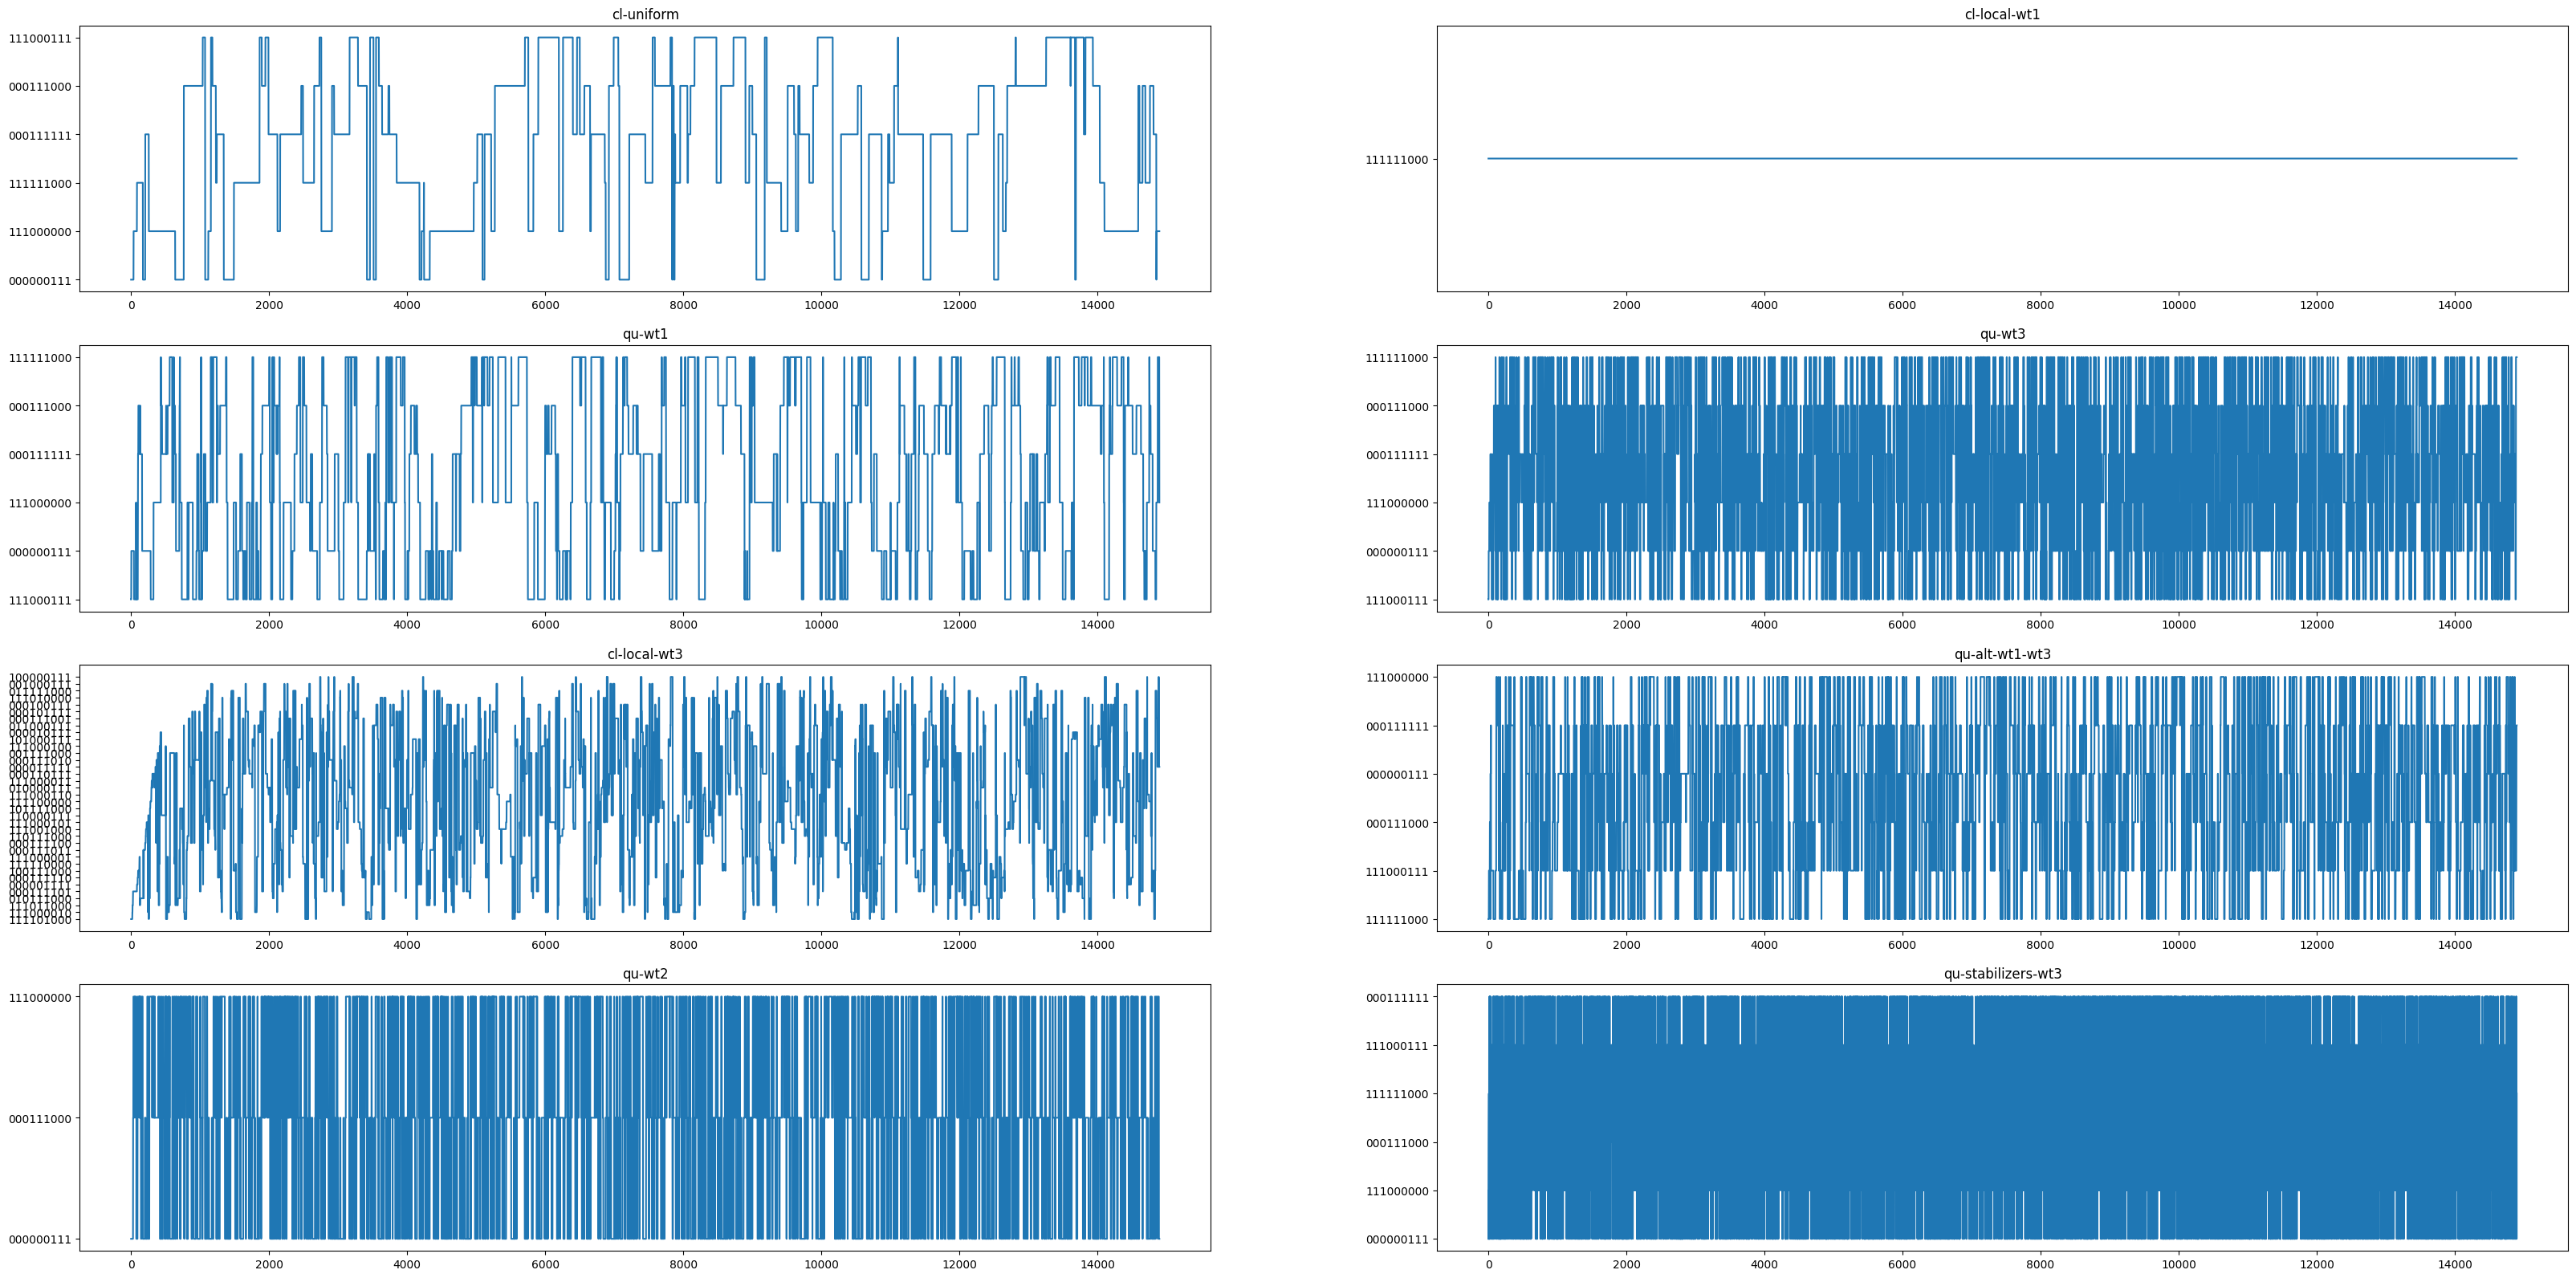

In [47]:
plt.figure(figsize=(25,16))
plot_mcmc_iterations(SAMPLINGDATA_BAS3[2])

##### Magnetisation

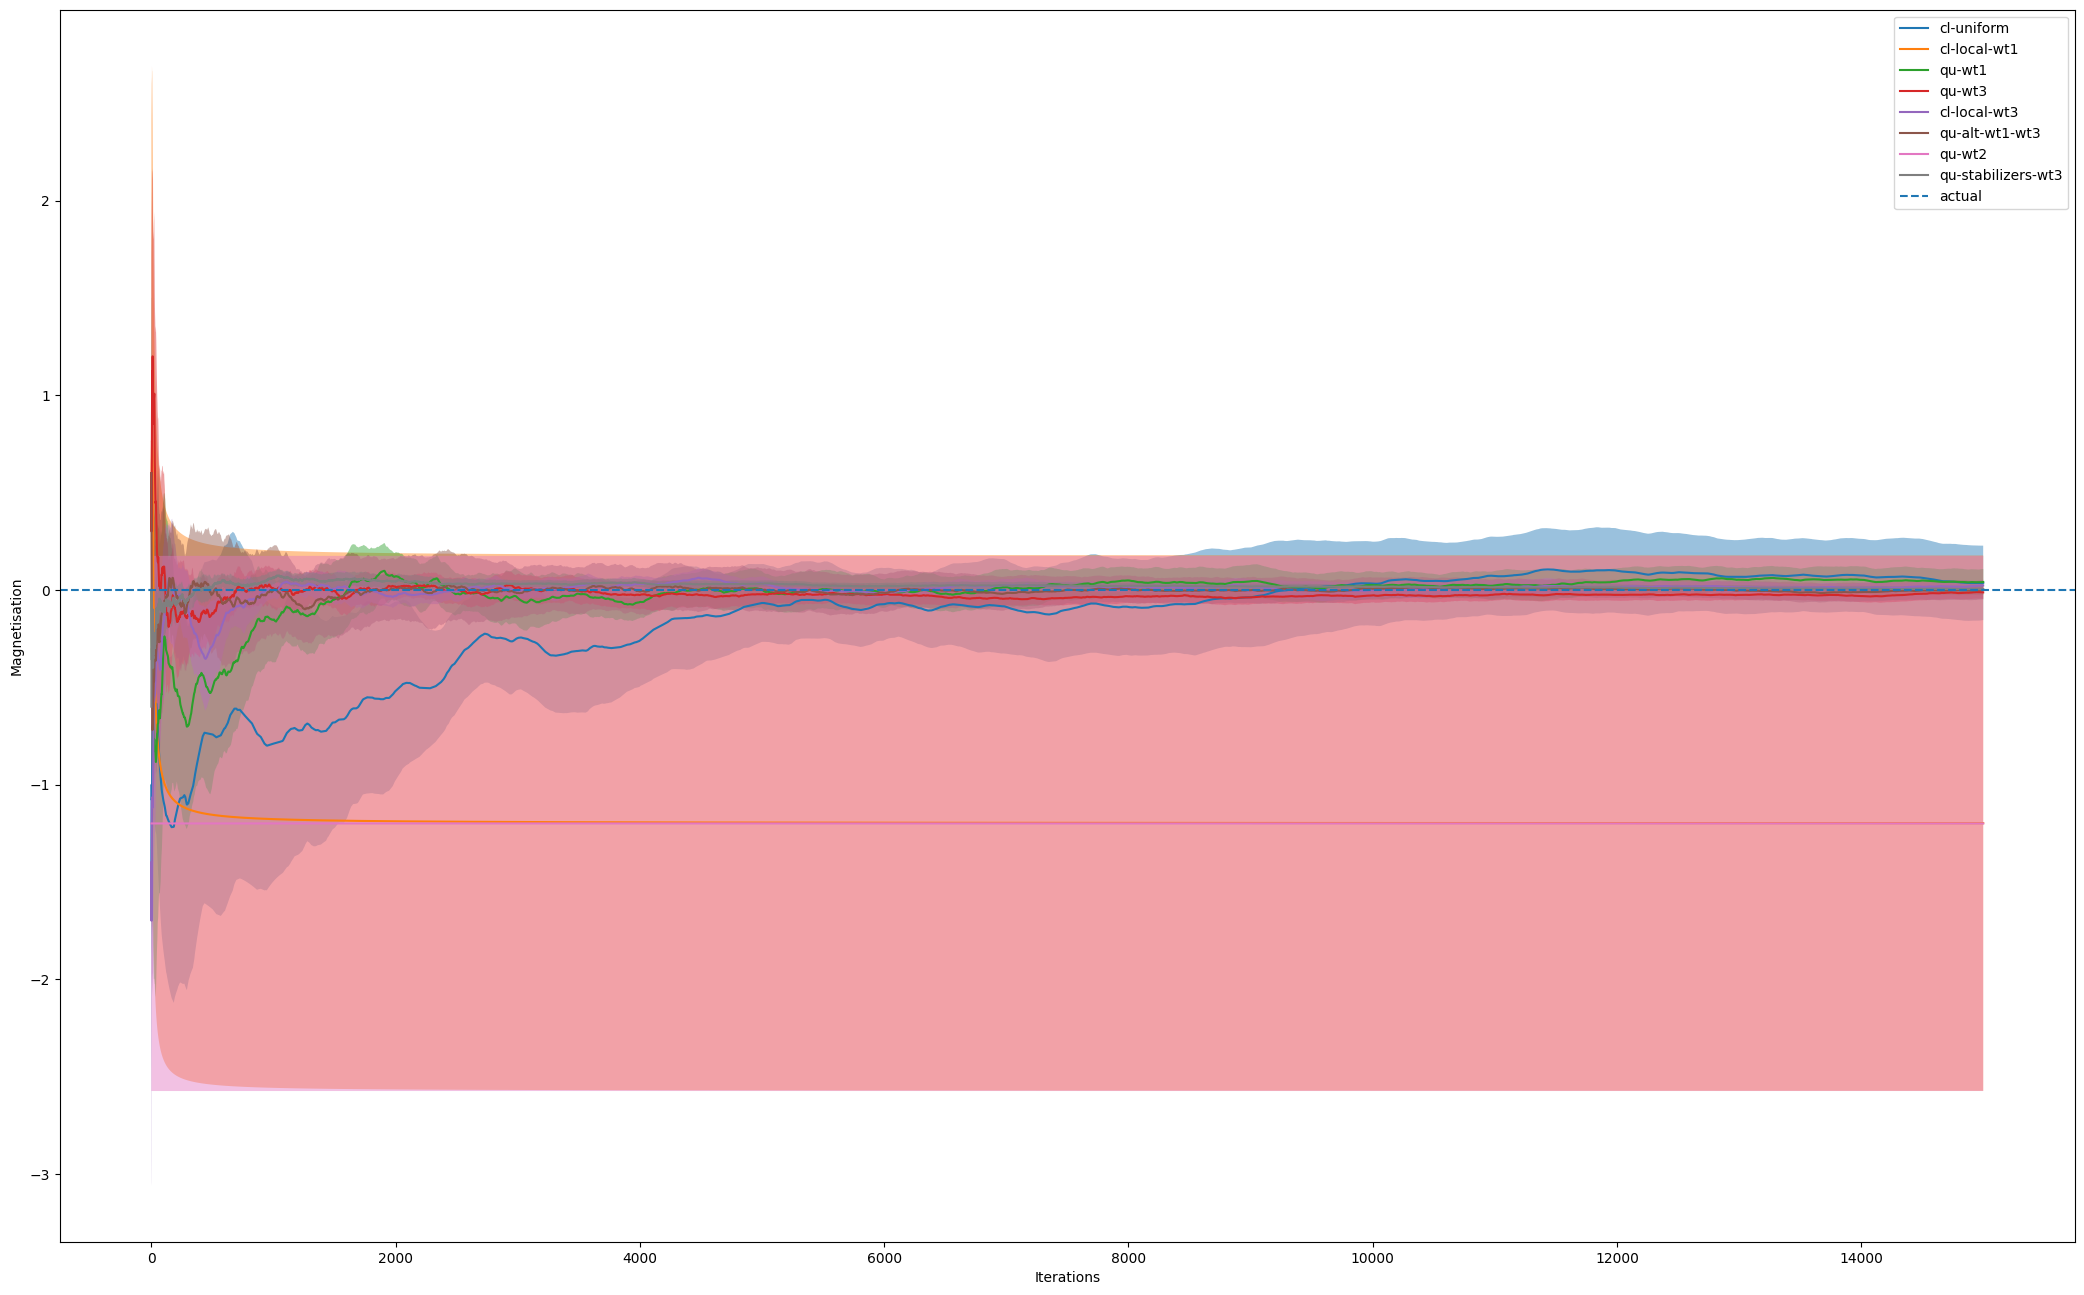

In [48]:
PLOT_MAGNETISATION(SAMPLINGRESULT_BAS3, save_plot= False)

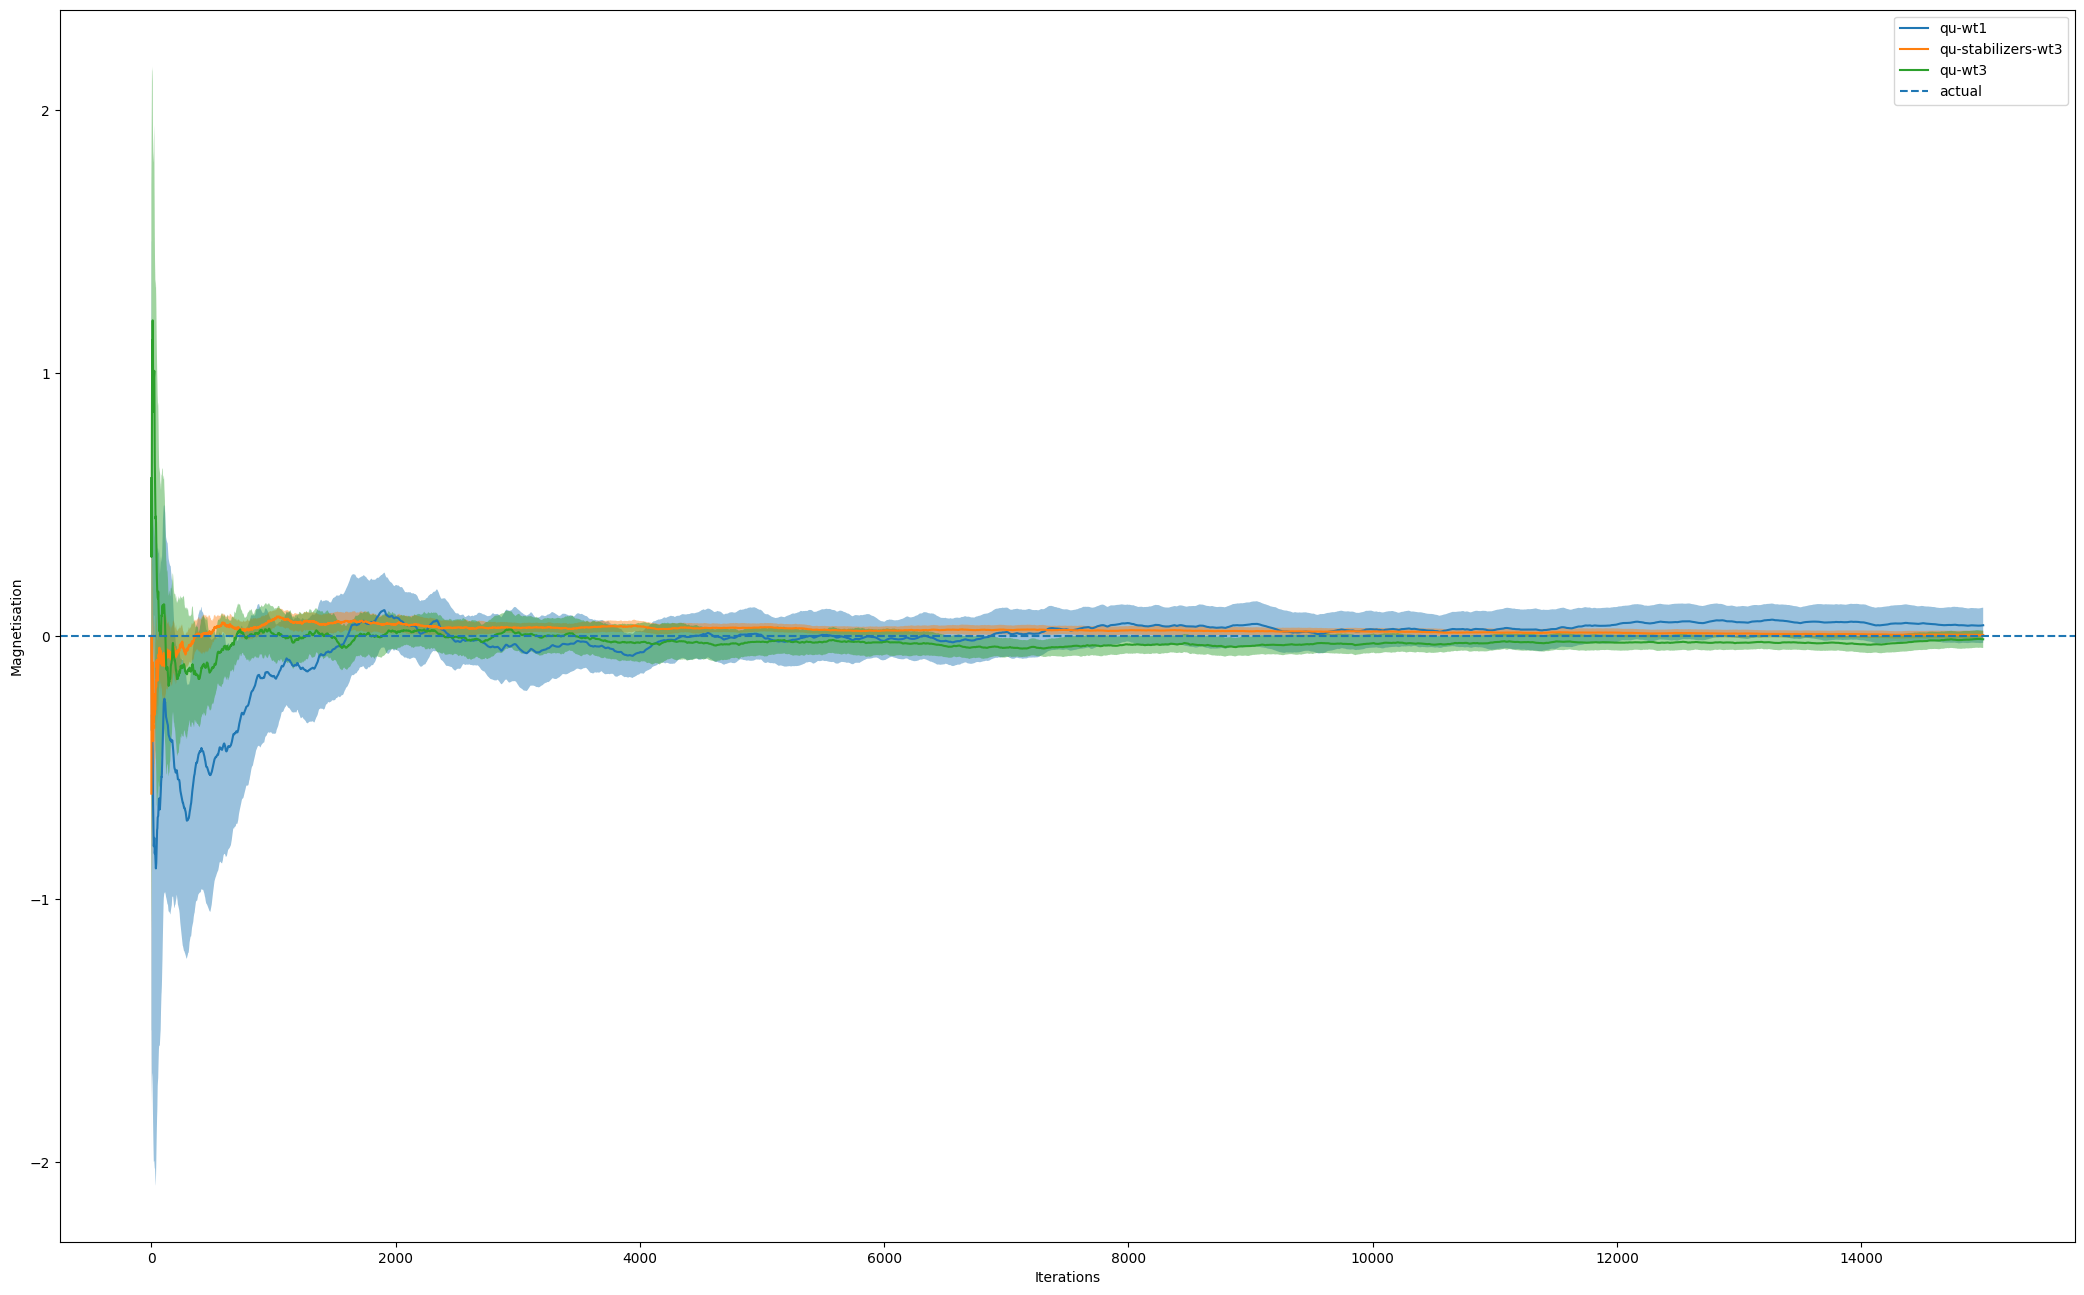

In [49]:
PLOT_MAGNETISATION(SAMPLINGRESULT_BAS3, mcmc_types_to_plot= ['qu-wt3', 'qu-stabilizers-wt3', 'qu-wt1'][::-1] , save_plot= False)

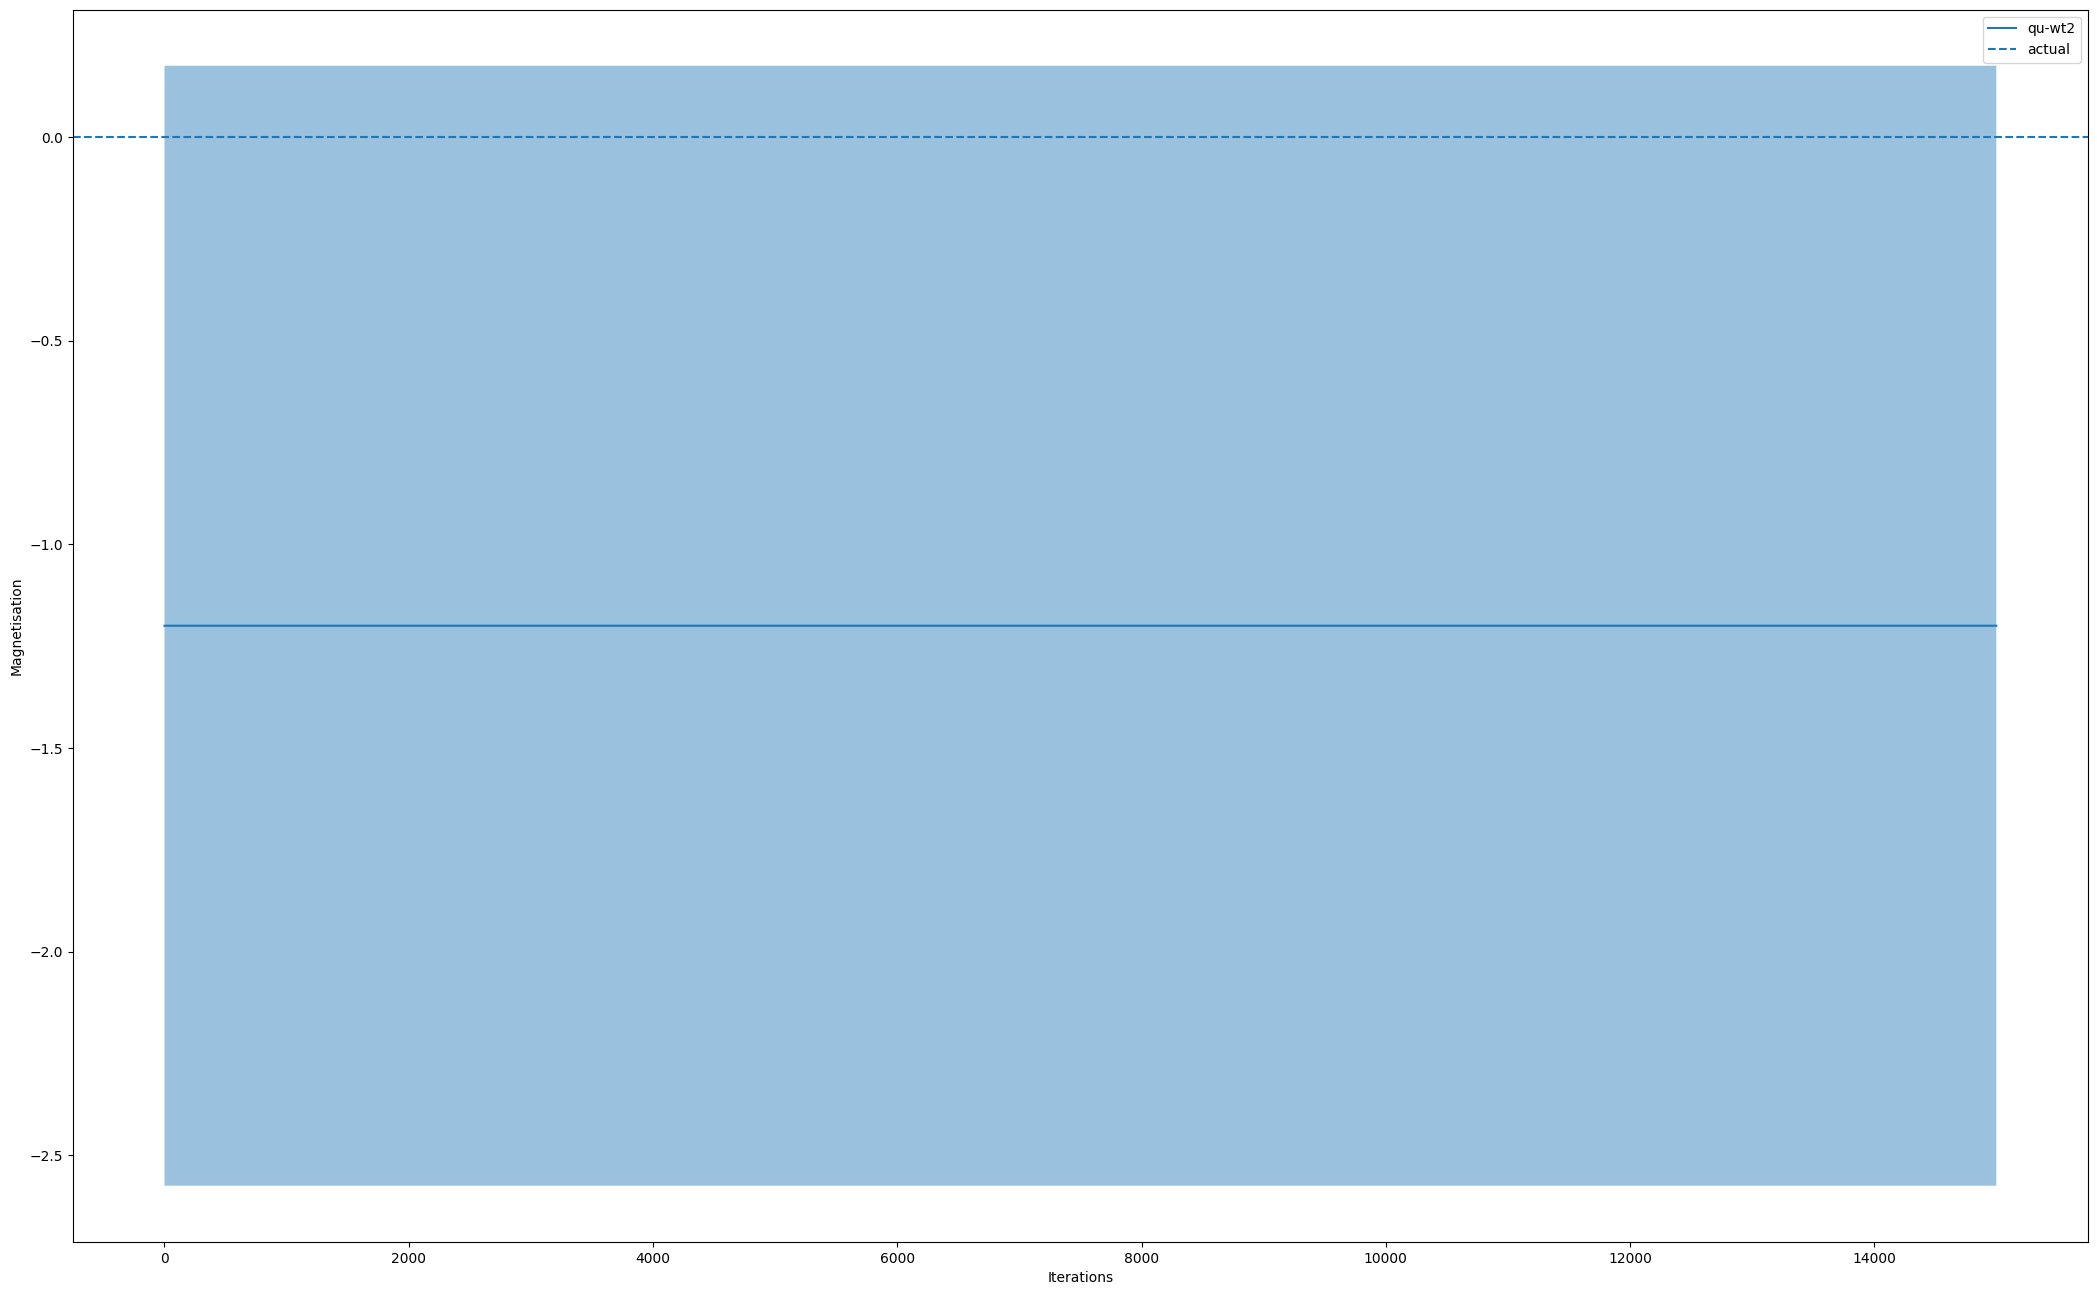

In [50]:

PLOT_MAGNETISATION(SAMPLINGRESULT_BAS3, mcmc_types_to_plot= ['qu-wt2'] , save_plot= False)

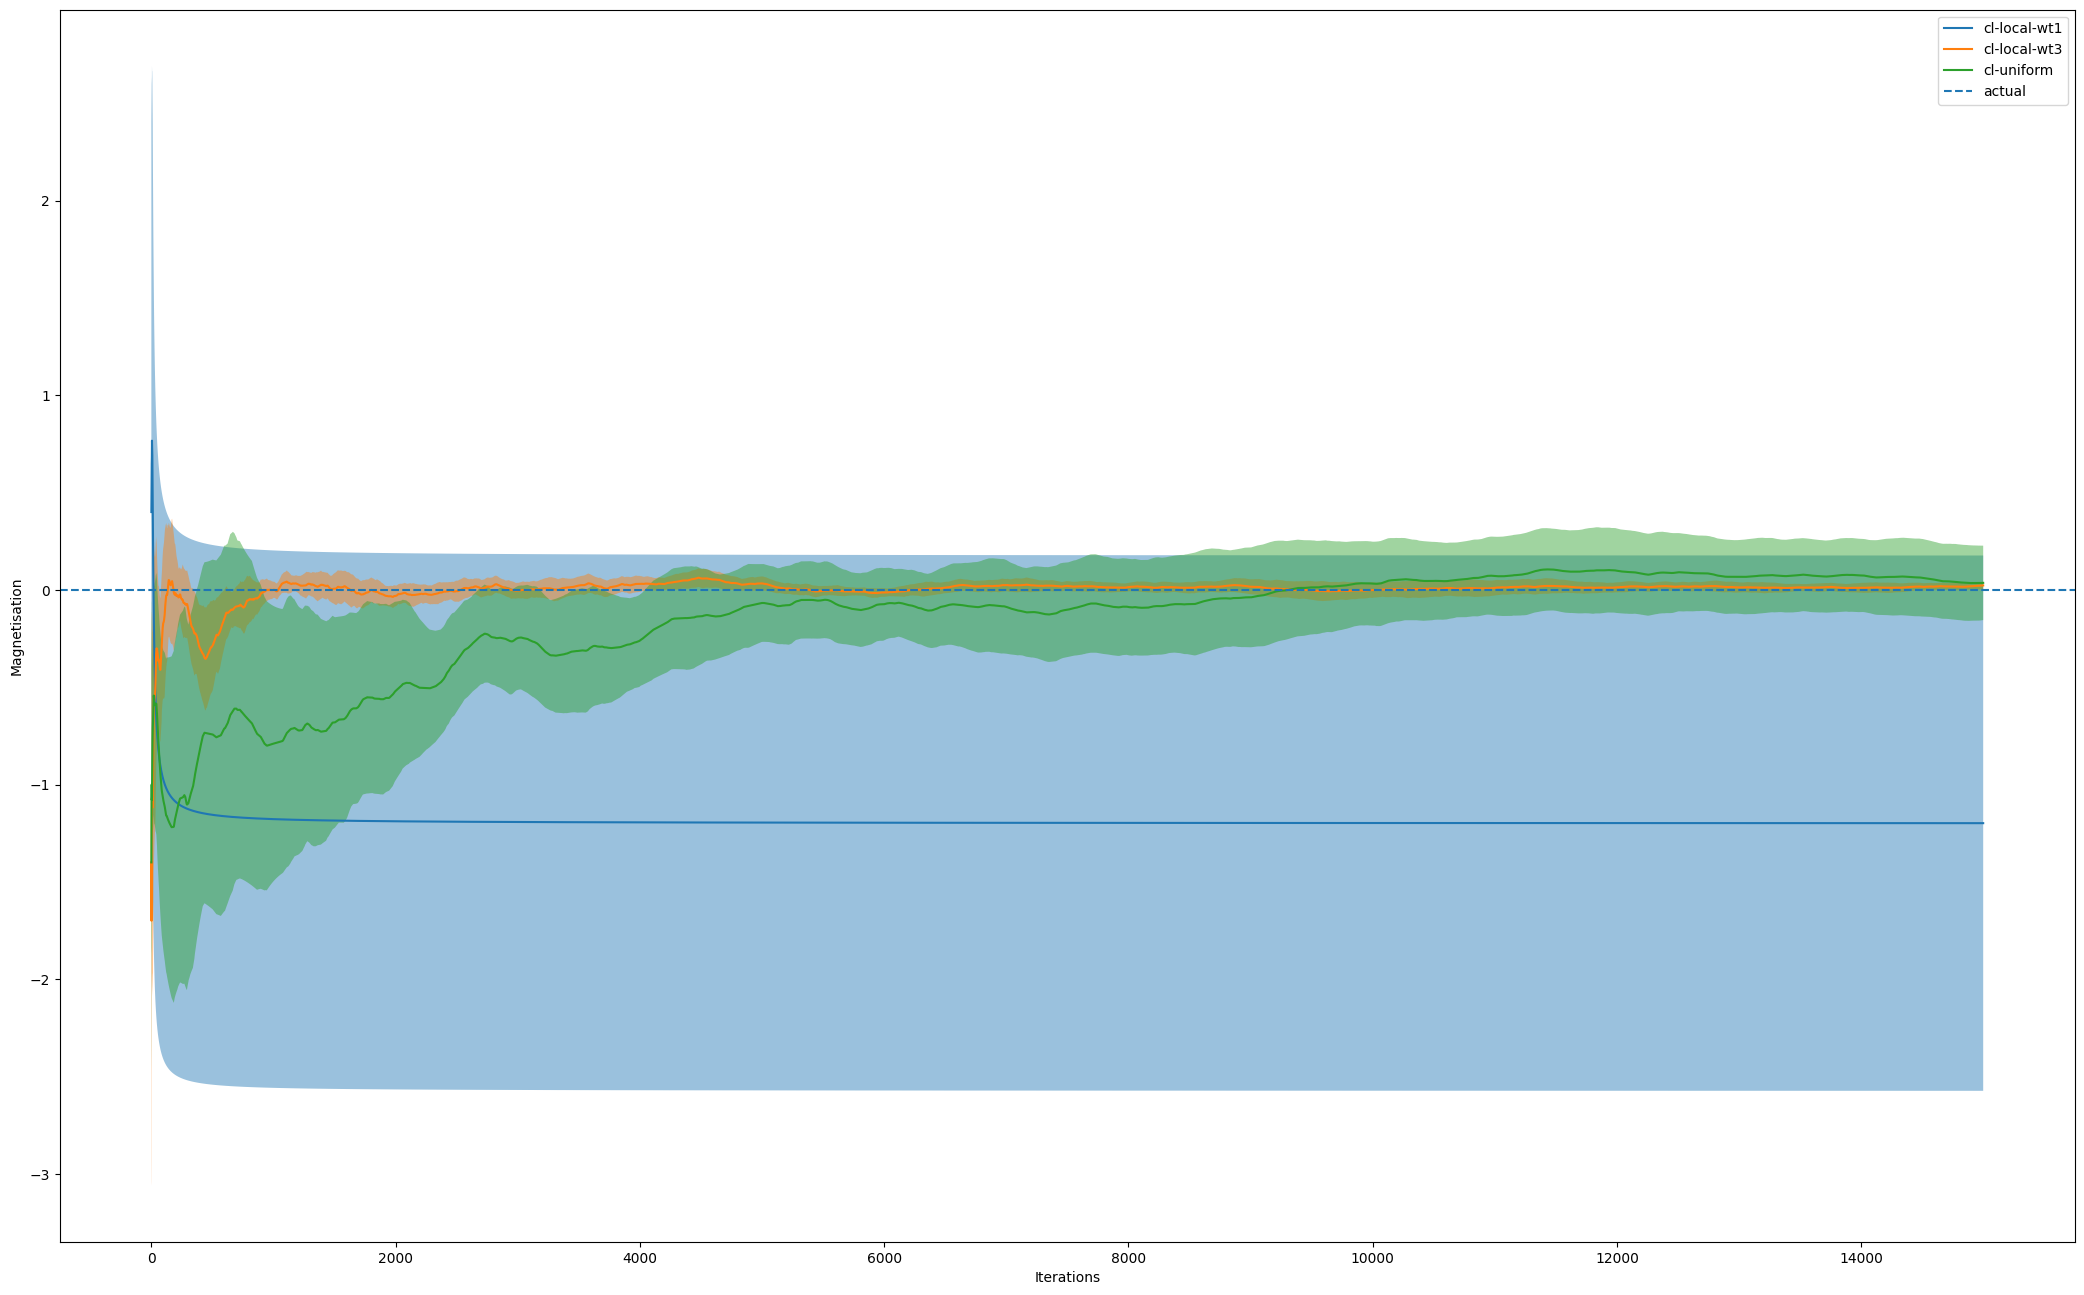

In [51]:
PLOT_MAGNETISATION(SAMPLINGRESULT_BAS3, mcmc_types_to_plot= ['cl-local-wt1' ,'cl-local-wt3', 'cl-uniform'] , save_plot= False)

##### KL Div

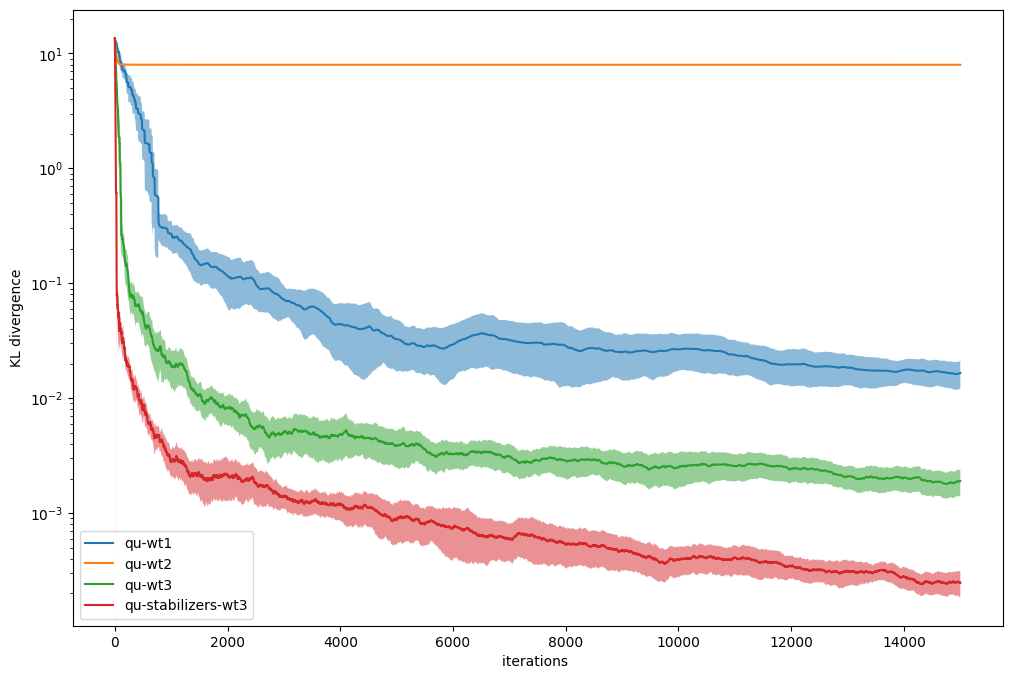

In [52]:
PLOT_KL_DIV(SAMPLINGRESULT_BAS3, mcmc_types_to_plot = ['qu-wt1', 'qu-wt2', 'qu-wt3', 'qu-stabilizers-wt3'],save_plot=False)

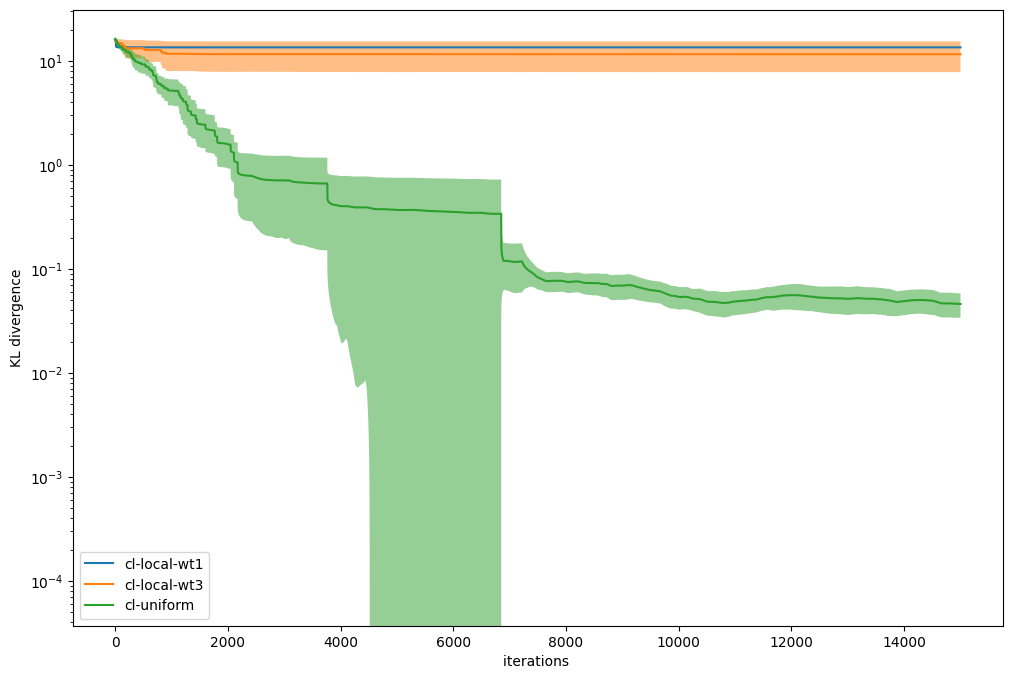

In [53]:
PLOT_KL_DIV(SAMPLINGRESULT_BAS3, mcmc_types_to_plot = ['cl-local-wt1' ,'cl-local-wt3', 'cl-uniform'] , save_plot= False)

##### Acceptance-prob STAT

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


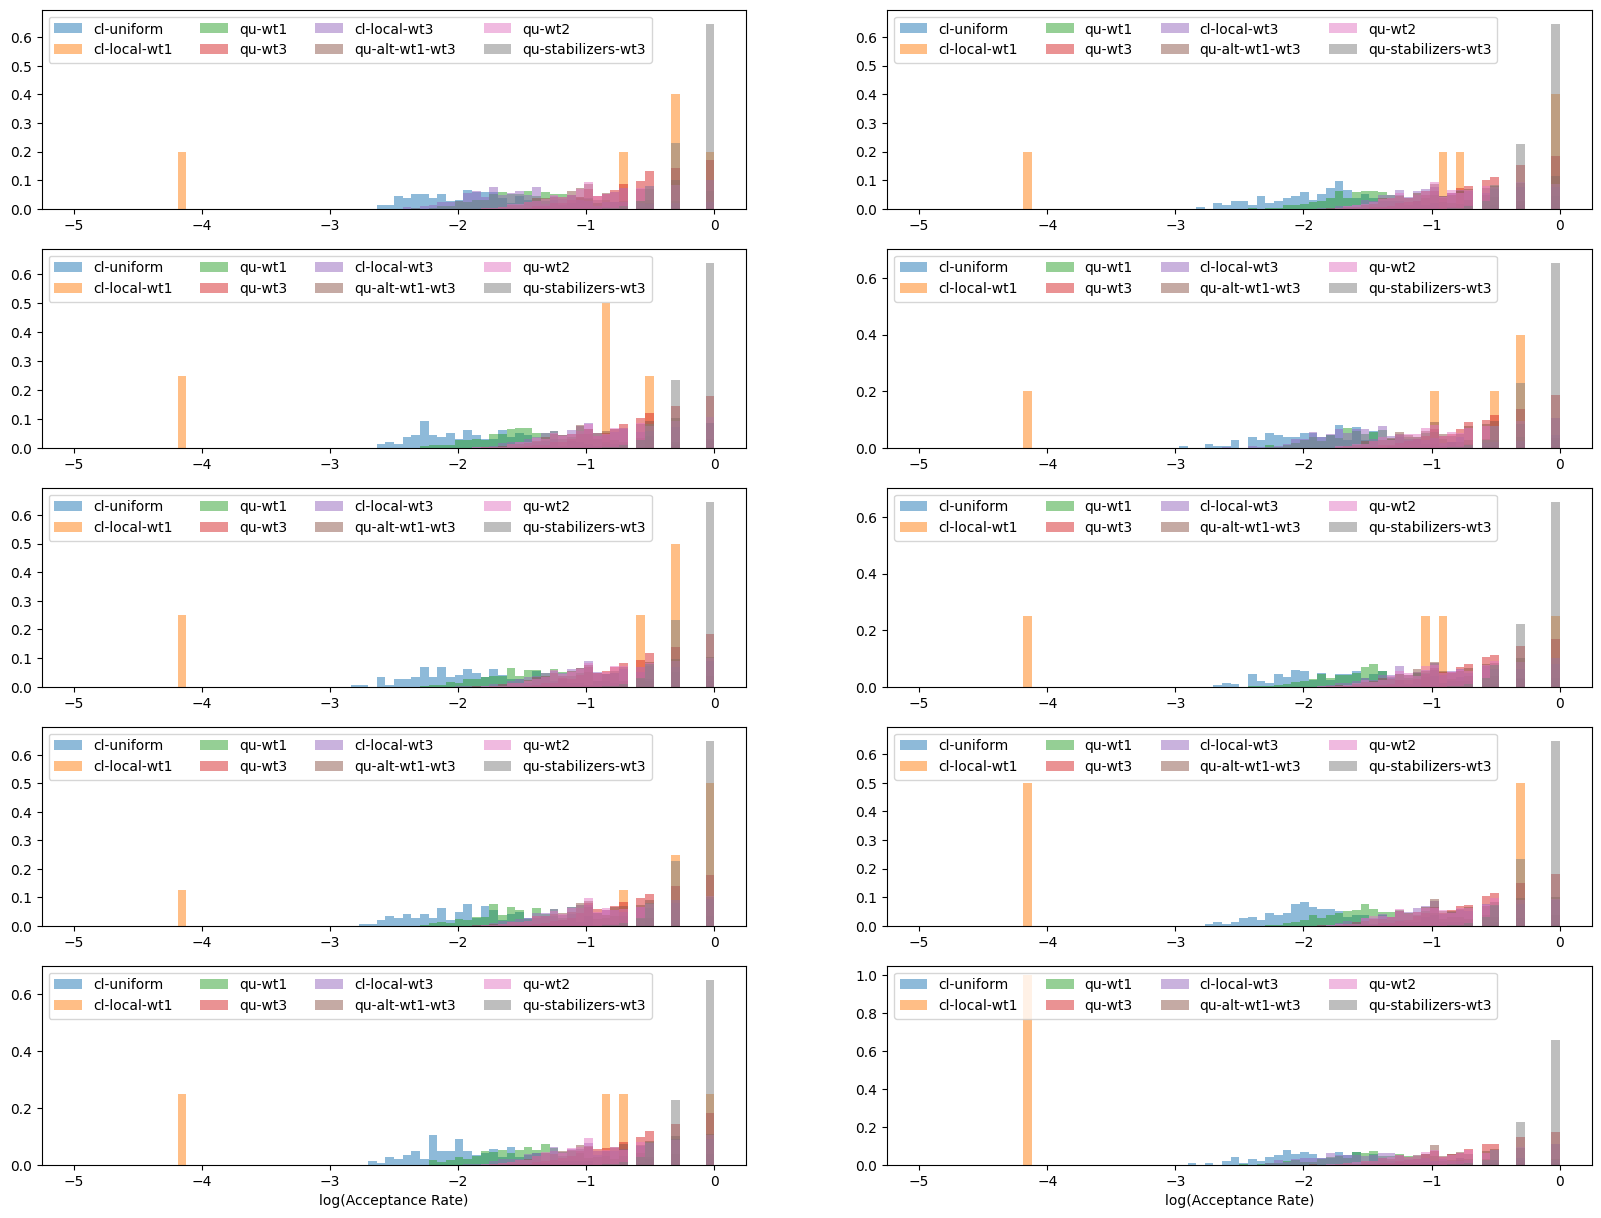

In [54]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3, save_plot= False, kwargs_acceptance_prob= {'histtype': 'stepfilled', 'stacked': True, 'density': True})


100%|██████████| 10/10 [00:00<00:00, 10.20it/s]


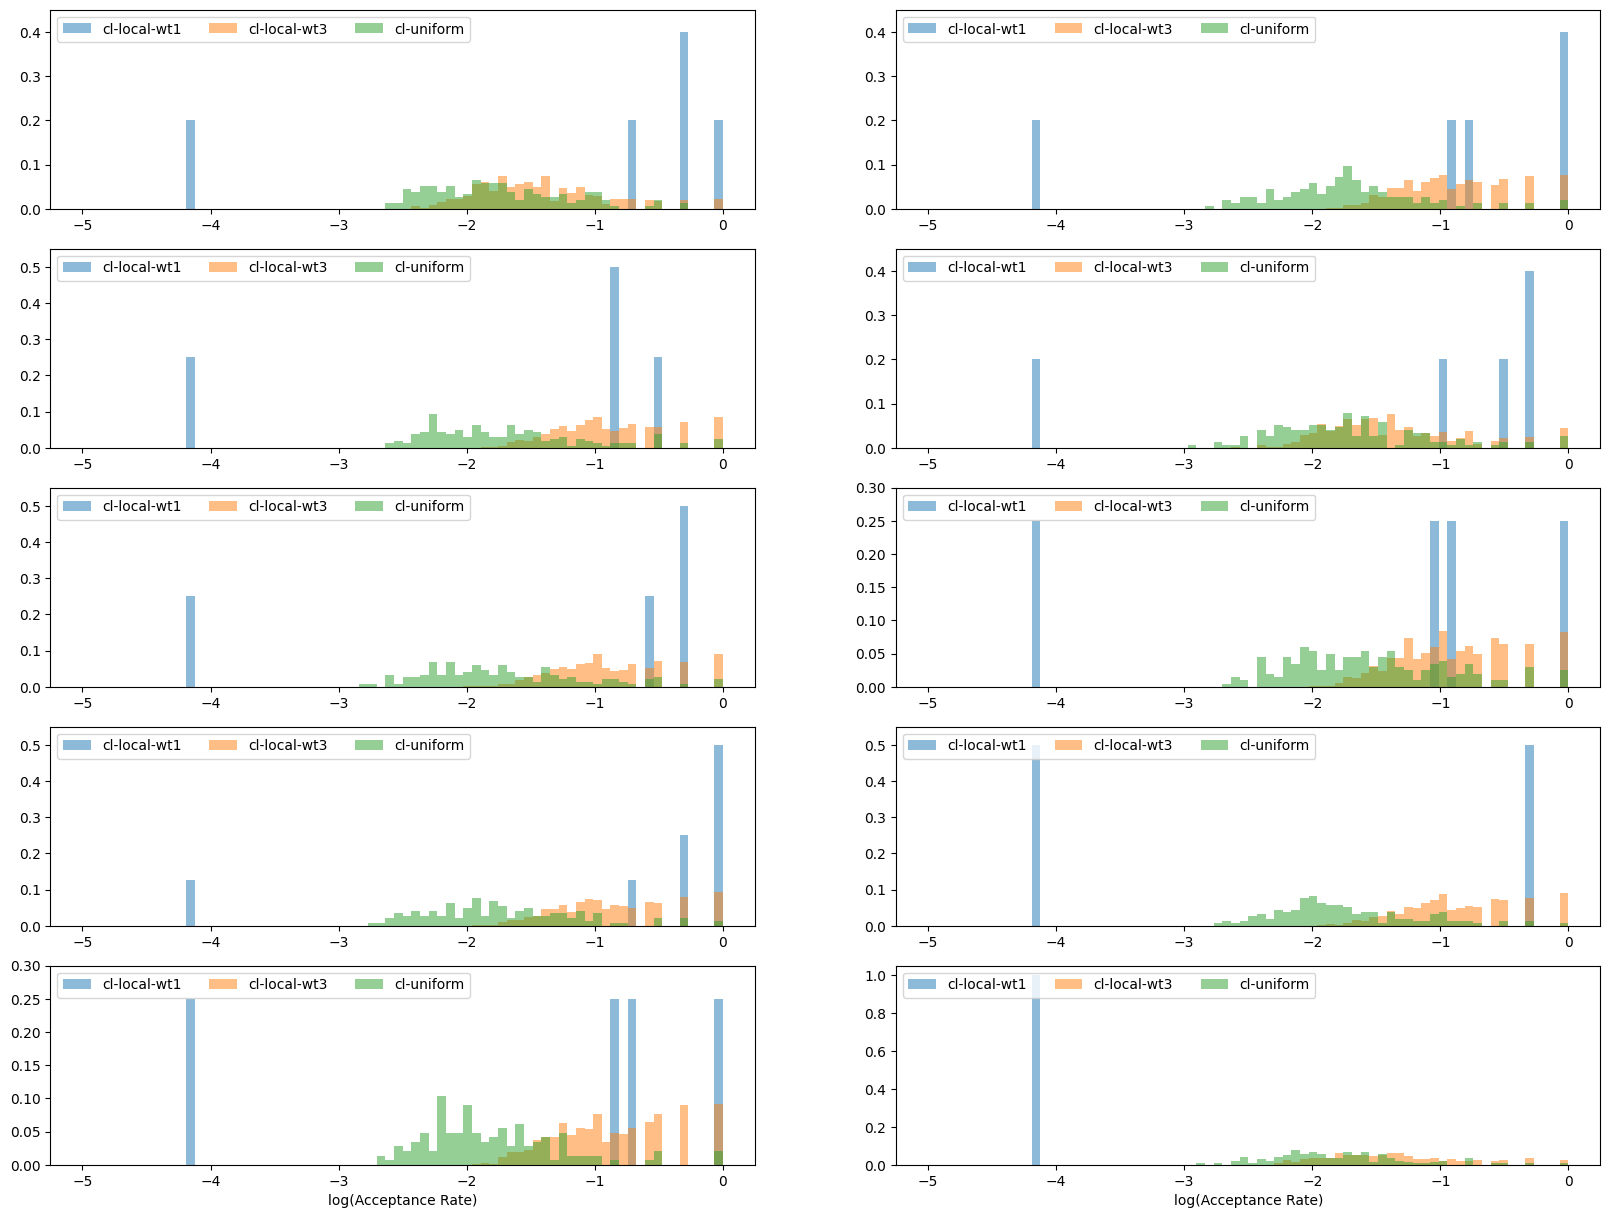

In [55]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3, mcmc_types_to_plot = ['cl-local-wt1' ,'cl-local-wt3', 'cl-uniform'] , save_plot= False, kwargs_acceptance_prob= {'histtype': 'stepfilled', 'stacked': True, 'density': True} )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


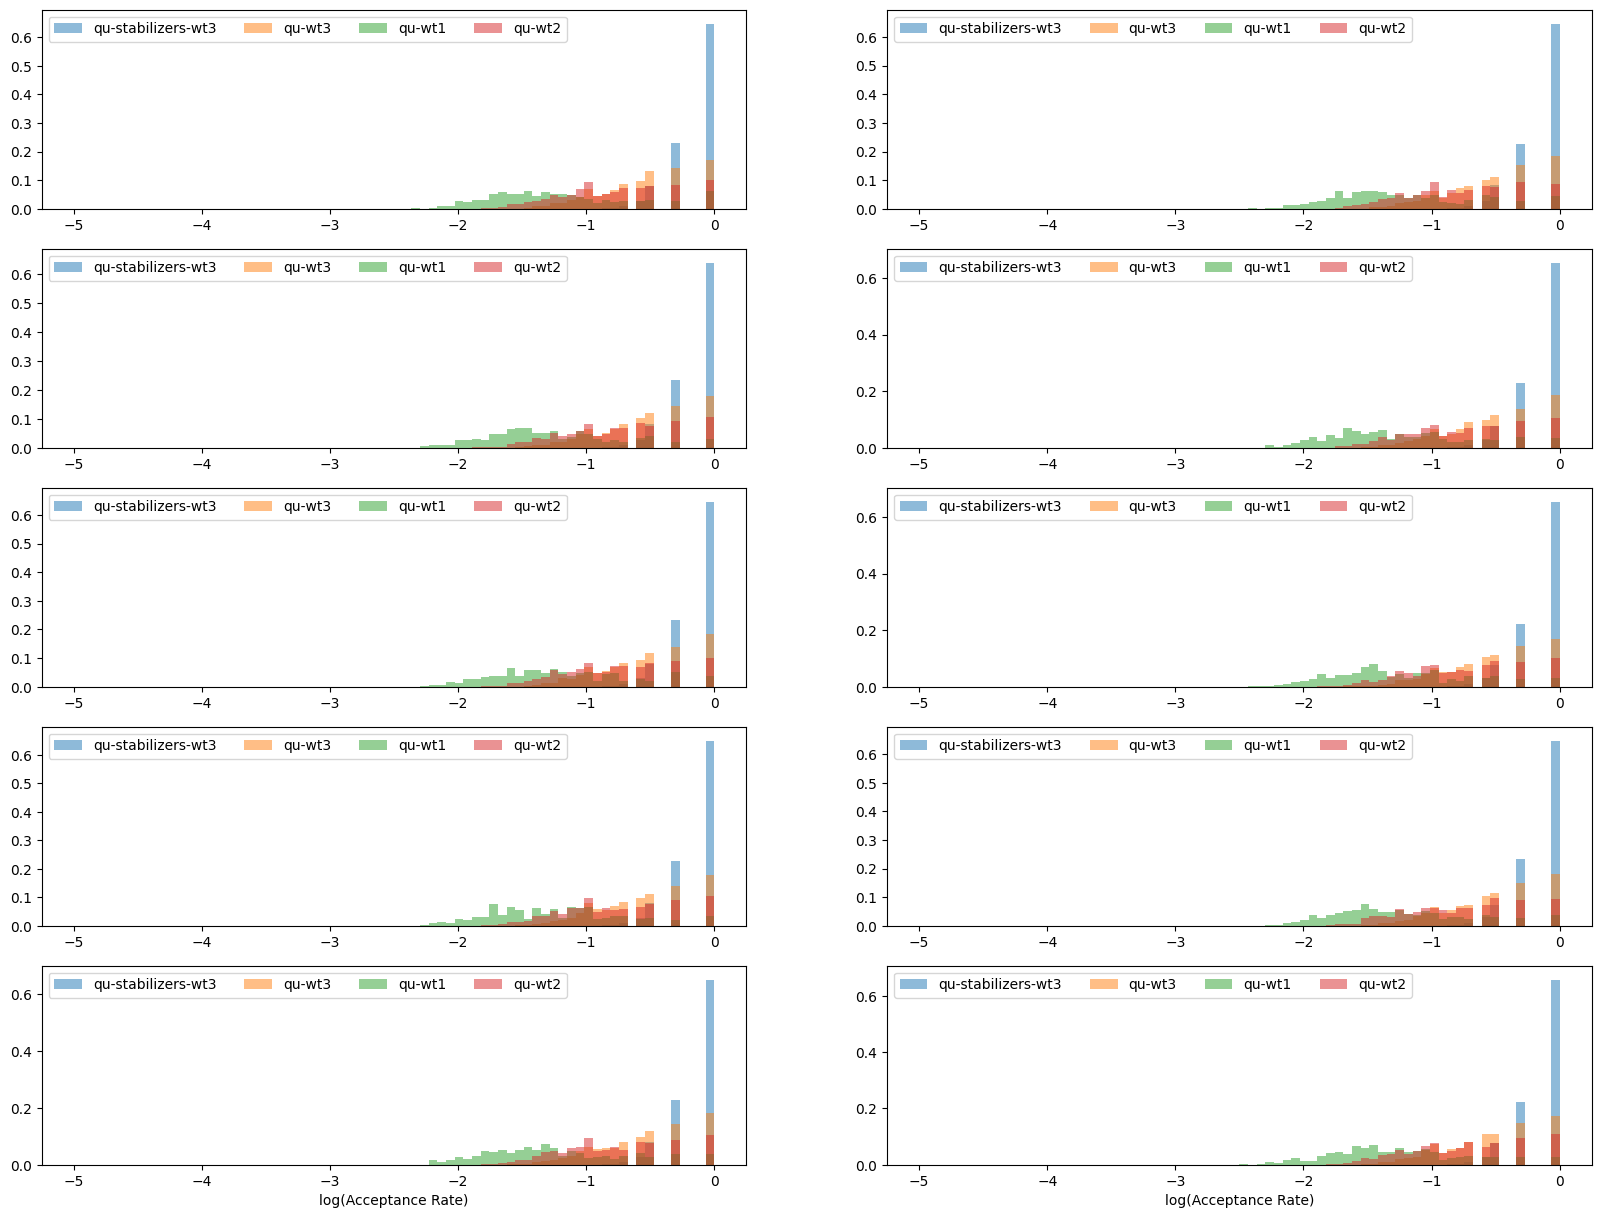

In [56]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3, mcmc_types_to_plot = ['qu-stabilizers-wt3', 'qu-wt3', 'qu-wt1', 'qu-wt2'], save_plot= False, kwargs_acceptance_prob= {'histtype': 'bar', 'stacked': False, 'density': True} )

100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


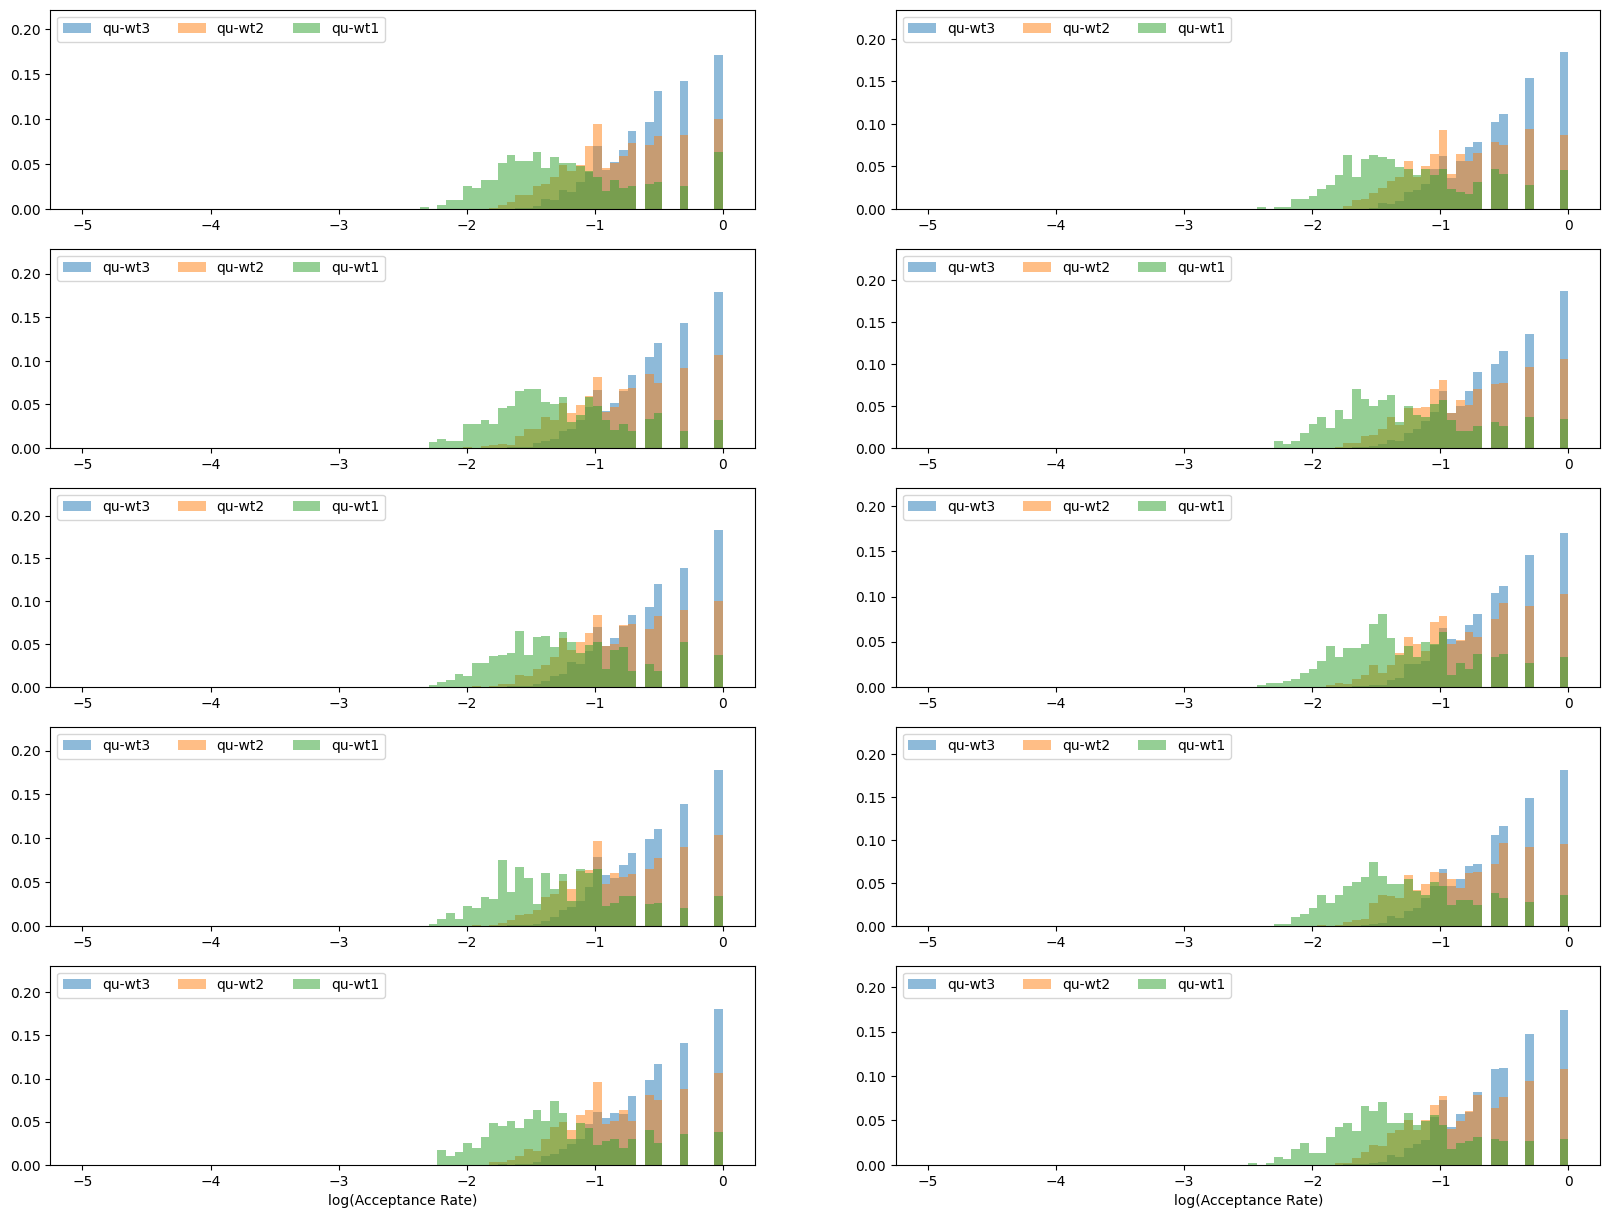

In [57]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3, mcmc_types_to_plot = ['qu-wt3', 'qu-wt2','qu-wt1'], save_plot= False, kwargs_acceptance_prob= {'histtype': 'stepfilled', 'stacked': True, 'density': True} )

##### Hamming STAT

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


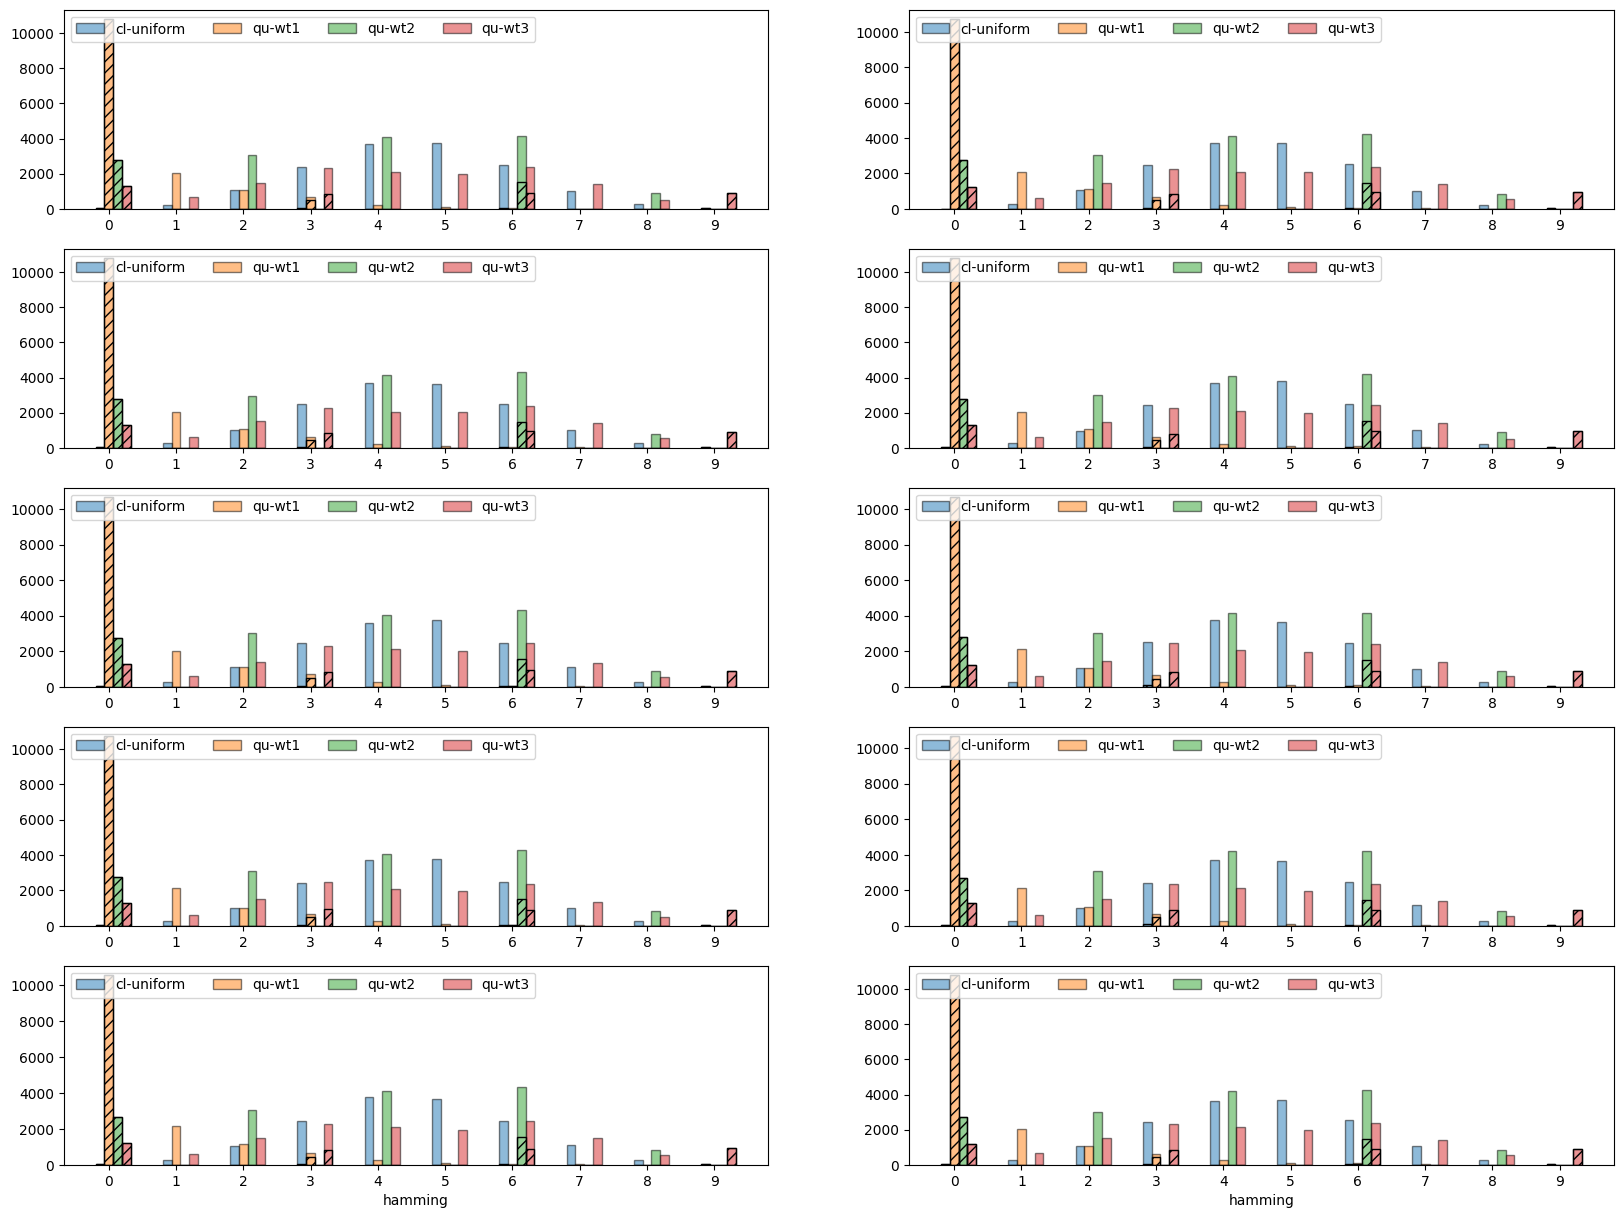

In [58]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3,mcmc_types_to_plot = ['cl-uniform','qu-wt1' ,'qu-wt2', 'qu-wt3'], statistic_to_plot= 'hamming' )

100%|██████████| 10/10 [00:00<00:00, 17.73it/s]


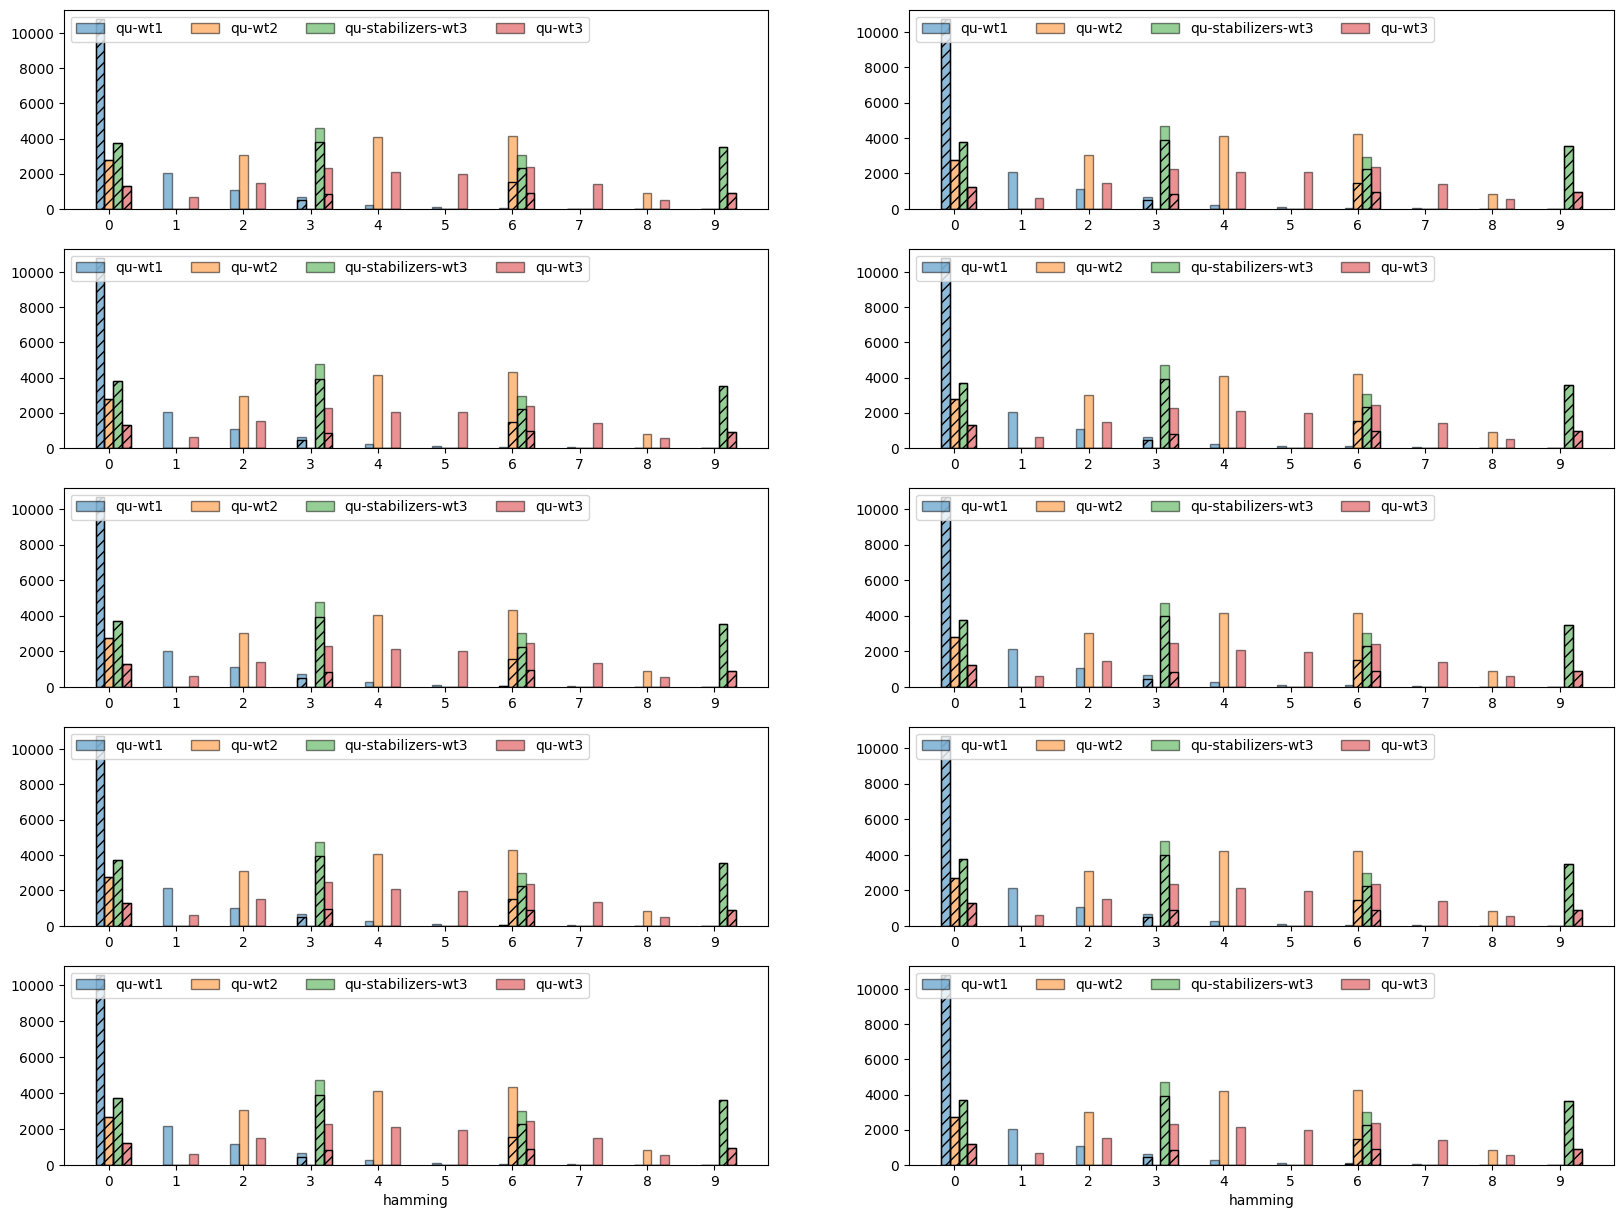

In [59]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3,mcmc_types_to_plot = ['qu-wt1' ,'qu-wt2','qu-stabilizers-wt3' , 'qu-wt3'], statistic_to_plot= 'hamming' )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 19.82it/s]


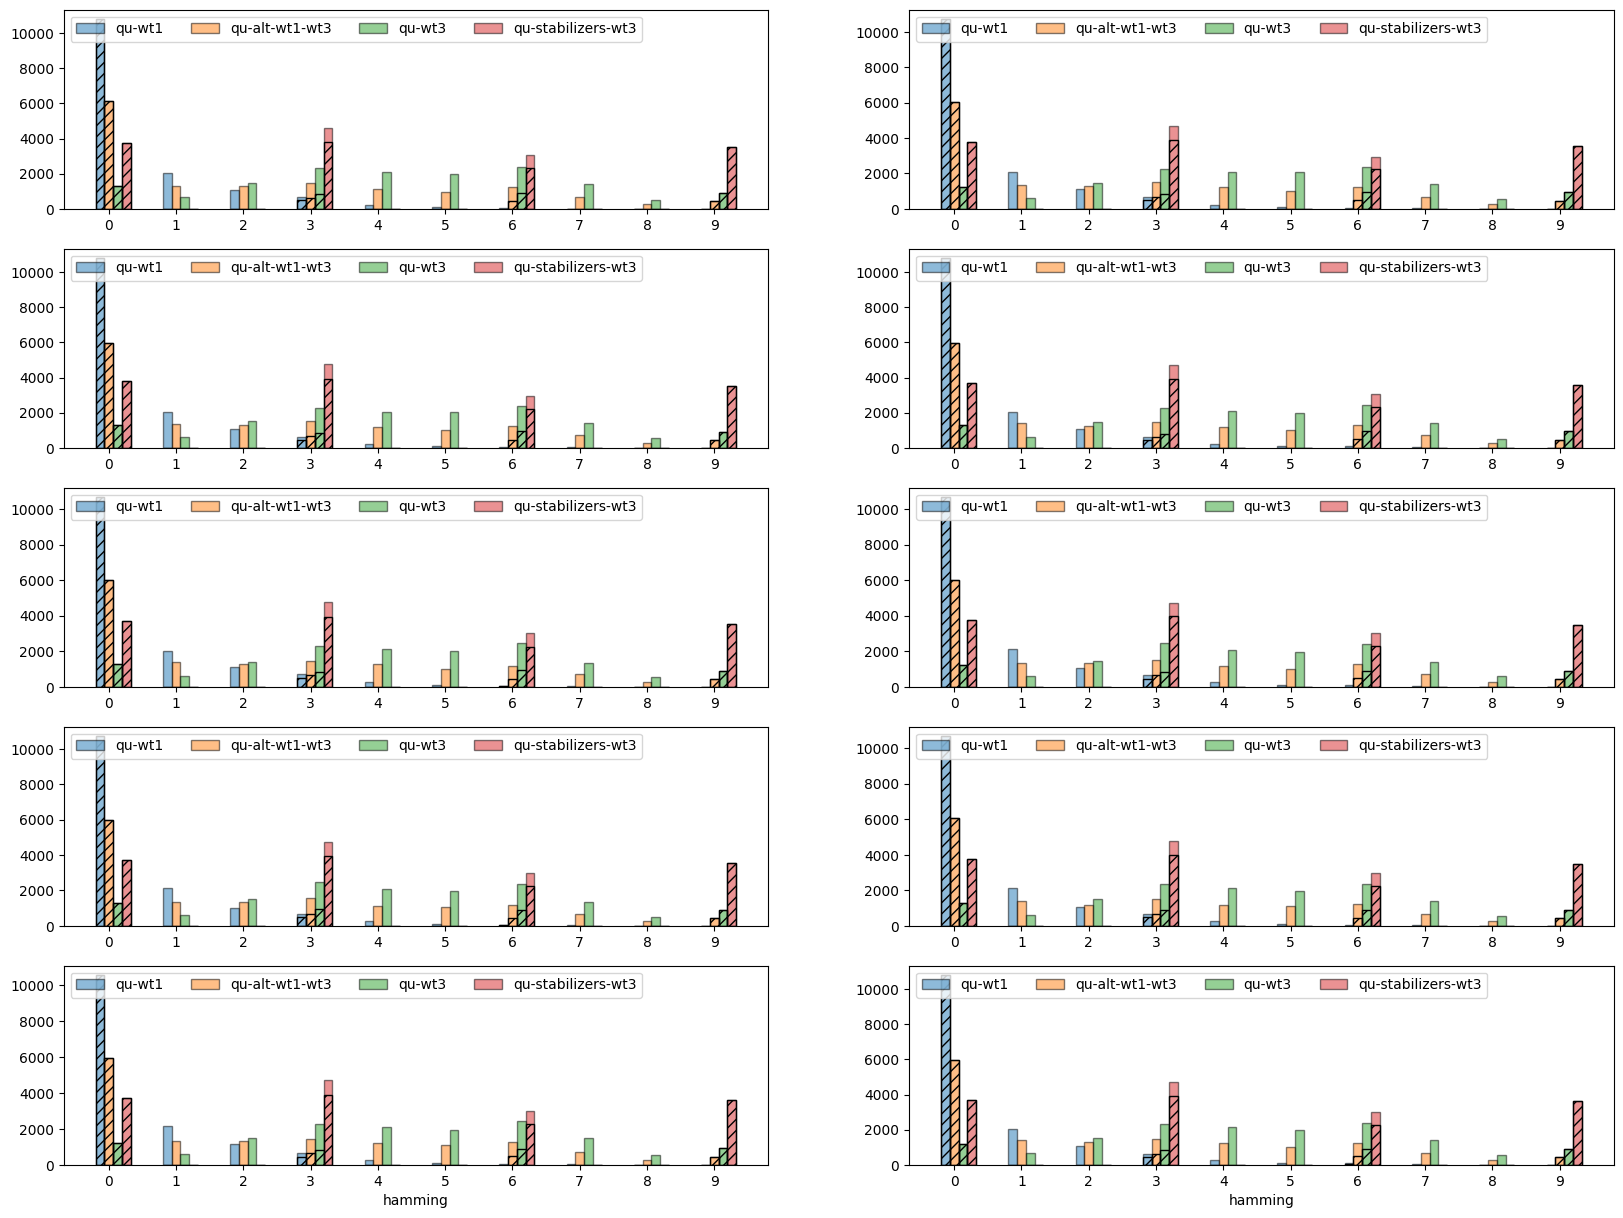

In [60]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3,mcmc_types_to_plot = ['qu-wt1' ,'qu-alt-wt1-wt3', 'qu-wt3', 'qu-stabilizers-wt3'], statistic_to_plot= 'hamming', )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 18.42it/s]


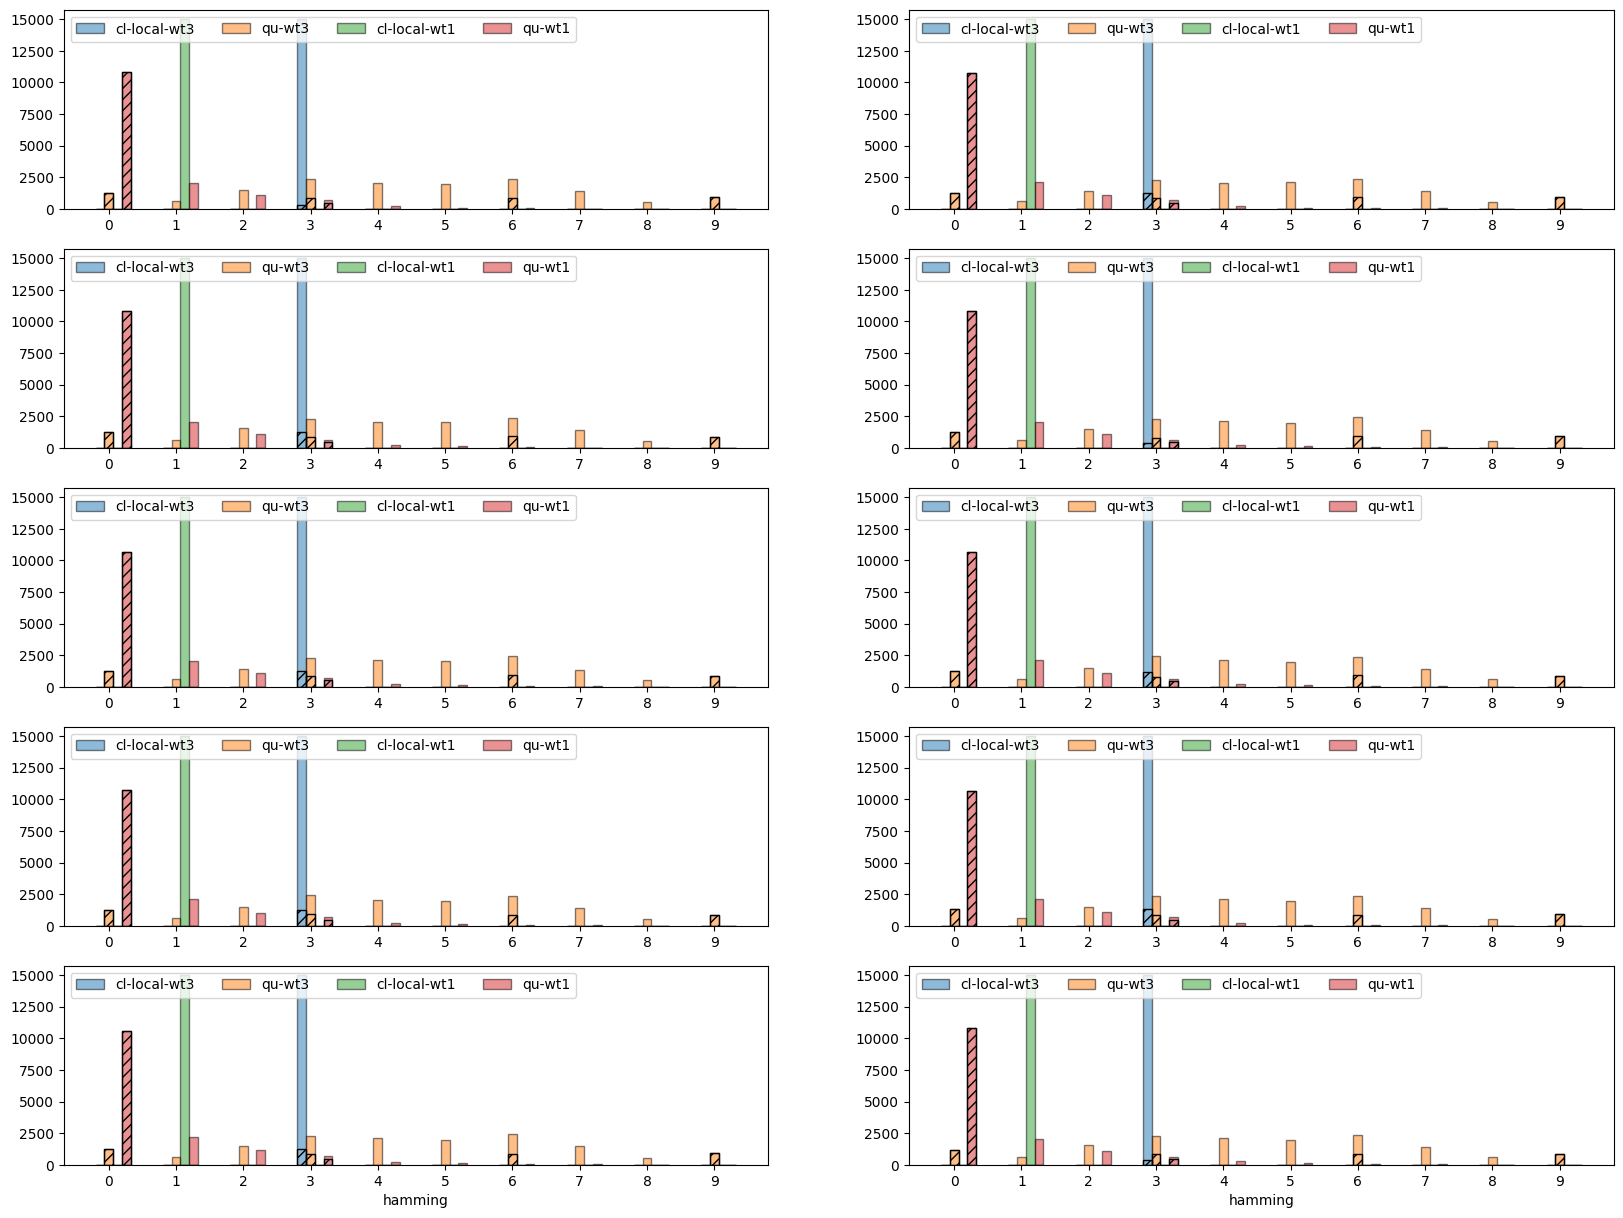

In [61]:
PLOT_MCMC_STATISTICS(SAMPLINGRESULT_BAS3,mcmc_types_to_plot = ['cl-local-wt3', 'qu-wt3', 'cl-local-wt1', 'qu-wt1'] , statistic_to_plot= 'hamming',)